In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
mnist = tf.keras.datasets.mnist

In [2]:
def leakyReLU(x, alpha):
    return tf.maximum(alpha*x, x)

In [3]:
class Dataset:
    def __init__(self, train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=True):
        self.train_img = train_images
        self.train_labels = train_labels
        self.shuffle = shuffle
        self.projection_data_path = projection_data_path
        self.metadata_tsv = '%s/metadata.tsv' % projection_data_path
        self.sprite = '%s/sprite_train_img.png' % projection_data_path
        if self.shuffle:
            idx = np.arange(len(self.train_img))
            np.random.shuffle(idx)
            self.train_img = self.train_img[idx]
            self.train_labels = self.train_labels[idx]
        
        whole_train = len(train_images)
        num_validation_samples = int(whole_train*validation)
        num_train_sample = whole_train - num_validation_samples
        
        self.train_img = self.train_img[:num_train_sample,:,:]
        self.train_img = self.prepare_data(self.train_img)
        self.train_labels = self.train_labels[:num_train_sample]
        
        self.test_img = self.prepare_data(test_images)
        self.test_labels = test_labels
        
        if not validation == 0.0:
            self.validation_labels = self.train_labels[num_train_sample+1:]
            self.validation_img = self.train_img[num_train_sample+1:,:,:]
            self.validation_img = self.prepare_data(self.validation_img)        
            if len(self.train_img.shape)==3:
                new_shape = self.validation_img.shape + (1,)
                self.validation_img = self.validation_img.reshape(new_shape)

        
        if len(self.train_img.shape)==3:
            new_shape = self.train_img.shape + (1,)
            self.train_img = self.train_img.reshape(new_shape)
            new_shape = self.test_img.shape + (1,)
            self.test_img = self.test_img.reshape(new_shape)
        
        self.data_shape = self.train_img.shape
        
    def normalize(self, images):
        # Normalize.
        max_value = np.amax(images)
        post = images/max_value
        return post
    
    # Function to pre-process the data.
    def prepare_data(self, images):
        post_images = self.normalize(images)
        return post_images
    
    def batches(self, batch_size):
        n_batches = self.train_img.shape[0]//batch_size
        for index in range(0, n_batches):
            x = self.train_img[index:index+batch_size, :, :, :]
            y = self.train_labels[index:index+batch_size]
            yield (x, y)

    def random_test(self):
        idx = np.arange(len(self.test_img))
        np.random.shuffle(idx)
        return [self.test_img[idx[0], :, :]]
    
    def random_train(self):
        idx = np.arange(len(self.train_img))
        np.random.shuffle(idx)
        return [self.train_img[idx[0], :, :]]
    
    def create_sprite_image(self, images):
        if os.path.isfile(self.sprite):
            os.remove(self.sprite)

        img_h = images.shape[1]
        img_w = images.shape[2]
        n_plots = int(np.ceil(np.sqrt(images.shape[0])))
        spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
        for i in range(n_plots):
            for j in range(n_plots):
                this_filter = i * n_plots + j
                if this_filter < images.shape[0]:
                    this_img = images[this_filter]
                    spriteimage[i * img_h:(i + 1) * img_h, j * img_w:(j + 1) * img_w] = this_img
        plt.imsave(self.sprite, spriteimage,cmap='gray')

    def create_tsv_file(self, img_labels):
        if os.path.isfile(self.metadata_tsv):
            os.remove(self.metadata_tsv)
        
        with open(self.metadata_tsv,'w') as f:
            f.write("Index\tLabel\n")
            for index,label in enumerate(img_labels):
                f.write("%d\t%d\n" % (index,label))

In [4]:
# Simple function to plot number images.
def plot_images(plt_num, images, dim, cmap):
    # Standard parameters for the plot.
    
    mpl.rcParams["figure.figsize"] = dim, dim
    fig = plt.figure()
    for i in range(0, plt_num):
        fig.add_subplot(1, 10, i+1)
        img = images[i, :, :, 0]
        plt.imshow(img, cmap=cmap)
    plt.show()

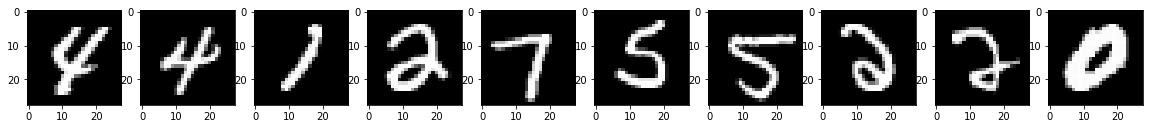

In [5]:
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()
projection_data_path = '/Users/adalbertoclaudioquiros/Documents/Code/UofG/PhD/GANs'
data = Dataset(train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=True)

plot_images(plt_num=10, images=data.train_img, dim=20, cmap='gray')

In [6]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    real_images = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='real_images')
    z_input = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    return real_images, z_input, learning_rate

In [7]:
def discriminator(images, reuse, alpha):
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input Shape: (None, 28, 28, 1)
        # Padding = 'Same' -> H_new = H_old // Stride
        
        # Conv layer.
        net = tf.layers.conv2d(inputs=images, filters=64, kernel_size=(5,5), strides=(2, 2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        net = leakyReLU(net, alpha)
        # Shape: (None, 16, 16, 64)
        
        # Conv layer.
        net = tf.layers.conv2d(inputs=net, filters=128, kernel_size=(5,5), strides=(2, 2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        net = tf.layers.batch_normalization(net, training=True)
        net = leakyReLU(net, alpha)
        # Shape: (None, 8, 8, 128)

        net = tf.layers.flatten(net, name='flatten')
        # Shape: (None, 8*8*128)

        # Dense.
        net = tf.layers.dense(net, 1024, activation=None)
        net = tf.layers.batch_normalization(net, training=True)
        net = leakyReLU(net, alpha)
        # Shape: (None, 1024)
        
        # Dense.
        logits = tf.layers.dense(net, 1, activation=None)
        # Shape: (None, 1)
        output = tf.nn.sigmoid(logits)
        
        return output, logits

In [8]:
def generator(z_input, out_channel_dim, reuse, is_train, alpha):
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # Dense layer.
        net = tf.layers.dense(inputs=z_input, units=1024, activation=None)
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape: (None, 1024)
        
        # Dense layer.
        net = tf.layers.dense(inputs=net, units=128*7*7, activation=None)
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape: (None, 128*7*7)
        
        net = tf.reshape(net, (-1, 7, 7, 128))
        # Shape: (None, 7, 7, 128)
        
        # Conv
        net = tf.layers.conv2d_transpose(inputs=net, filters=128, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape: (None, 14, 14, 128)
        
        # Conv
        net = tf.layers.conv2d_transpose(inputs=net, filters=128, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        net = tf.layers.batch_normalization(net, training=is_train)
        net = leakyReLU(net, alpha)
        # Shape: (None, 14, 14, 128)
        
        # Conv
        logits = tf.layers.conv2d_transpose(inputs=net, filters=out_channel_dim, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # Shape: (None, 28, 28, 1)
        output = tf.nn.sigmoid(logits)
        
        return output

In [9]:
def show_generated(session, output_fake, n_images, z_input, image_type):
    cmap = None if image_type == 'RGB' else 'gray'
    z_dim = z_input.get_shape()[-1]
    sample_z = np.random.uniform(low=-1., high=1., size=(n_images, z_dim))
    feed_dict = {z_input:sample_z}
    gen_samples = session.run(output_fake, feed_dict=feed_dict)
    
    gen_samples *= 255.
    
    plot_images(plt_num=n_images, images=gen_samples, dim=10, cmap=cmap)    

In [27]:
def loss(real_images, z_input, out_channel_dim, alpha):
    
    # Generator.
    fake_images = generator(z_input, out_channel_dim=out_channel_dim, reuse=False, is_train=True, alpha=alpha)
    
    # Discriminator.
    output_fake, logits_fake = discriminator(images=fake_images, reuse=False, alpha=alpha) 
    output_real, logits_real = discriminator(images=real_images, reuse=True, alpha=alpha)
    
    # Discriminator loss.
    logits_diff_real_fake = logits_real - tf.reduce_mean(logits_fake, axis=0, keepdims=True)
    logits_diff_fake_real = logits_fake - tf.reduce_mean(logits_real, axis=0, keepdims=True)

    loss_dis_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_diff_real_fake, 
                                                                           labels=tf.ones_like(output_fake)))
    loss_dis_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_diff_fake_real, 
                                                                           labels=tf.zeros_like(output_fake)))
    loss_dis = loss_dis_real + loss_dis_fake

    # Generator loss.
    loss_gen_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_diff_fake_real, 
                                                                           labels=tf.ones_like(output_fake)))
    loss_gen_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_diff_real_fake, 
                                                                           labels=tf.zeros_like(output_fake)))
    loss_gen = loss_gen_real + loss_gen_fake
    
    return loss_dis, loss_gen

In [28]:
def optimization(loss_dis, loss_gen, learning_rate, beta1):
    trainable_variables = tf.trainable_variables()
    generator_variables = [variable for variable in trainable_variables if variable.name.startswith('generator')]
    discriminator_variables = [variable for variable in trainable_variables if variable.name.startswith('discriminator')]
    
    # Handling Batch Normalization.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_generator = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                                 beta1=beta1).minimize(loss_gen, var_list=generator_variables)
        train_discriminator = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                                     beta1=beta1).minimize(loss_dis, var_list=discriminator_variables)    
    return train_generator, train_discriminator

In [29]:
def train(epochs, batch_size, z_dim, learning_rate, beta1, dataset, image_type, alpha, n_critic):
    
    dataset_size, image_width, image_height, image_channels = dataset.data_shape
    
    real_images, z_input, learning_rate_input = model_inputs(image_width=image_width, image_height=image_height, 
                                                            image_channels=image_channels, z_dim=z_dim)
    loss_dis, loss_gen = loss(real_images=real_images, z_input=z_input, out_channel_dim=image_channels, alpha=alpha)
    train_generator, train_discriminator = optimization(loss_dis=loss_dis, loss_gen=loss_gen, learning_rate=learning_rate_input, 
                                                       beta1=beta1)
    
    output_gen = generator(z_input=z_input, out_channel_dim=image_channels, reuse=True, is_train=False, alpha=alpha)

    losses = list()
    run_epochs = 0
    
    show_epochs = 100
    print_epochs = 10
    n_images = 10
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        for epoch in range(epochs+1):
            get_batches = data.batches(batch_size)
            for batch_images, batch_labels in get_batches.__iter__():
                z_batch = np.random.uniform(low=-1., high=1., size=(batch_size, z_dim))
                feed_dict = {z_input:z_batch, real_images:batch_images, learning_rate_input: learning_rate}
                
                # Update critic and clip gradients.
                session.run(train_discriminator, feed_dict=feed_dict)
                
                # Update generator after n_critic updates from discriminator.
                if run_epochs%n_critic or n_critic==1:
                    session.run(train_generator, feed_dict=feed_dict)
                
                # Print losses and Generate samples.             
                if run_epochs%print_epochs==0:
                    feed_dict = {z_input:z_batch, real_images:batch_images}
                    epoch_loss_dis = session.run(loss_dis, feed_dict=feed_dict)
                    epoch_loss_gen = session.run(loss_gen, feed_dict=feed_dict)
                    losses.append((epoch_loss_dis, epoch_loss_gen))
                    print('Epochs %s/%s: Generator Loss: %s. Discriminator Loss: %s' % (epoch, epochs, np.round(epoch_loss_gen, 3), 
                                                                                        np.round(epoch_loss_dis, 3)))
                if run_epochs%show_epochs == 0:
                    show_generated(session=session, output_fake=output_gen, n_images=n_images, z_input=z_input, 
                                   image_type=image_type)
                run_epochs+=1


Epochs 0/5: Generator Loss: 1.215. Discriminator Loss: 1.646


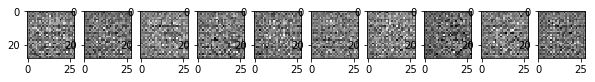

Epochs 0/5: Generator Loss: 2.992. Discriminator Loss: 0.525
Epochs 0/5: Generator Loss: 3.647. Discriminator Loss: 0.362
Epochs 0/5: Generator Loss: 3.781. Discriminator Loss: 0.343
Epochs 0/5: Generator Loss: 3.869. Discriminator Loss: 0.333
Epochs 0/5: Generator Loss: 4.144. Discriminator Loss: 0.308
Epochs 0/5: Generator Loss: 4.112. Discriminator Loss: 0.306
Epochs 0/5: Generator Loss: 4.355. Discriminator Loss: 0.257
Epochs 0/5: Generator Loss: 4.207. Discriminator Loss: 0.282
Epochs 0/5: Generator Loss: 4.442. Discriminator Loss: 0.25
Epochs 0/5: Generator Loss: 4.479. Discriminator Loss: 0.259


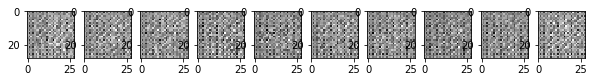

Epochs 0/5: Generator Loss: 4.577. Discriminator Loss: 0.245
Epochs 0/5: Generator Loss: 4.975. Discriminator Loss: 0.186
Epochs 0/5: Generator Loss: 4.631. Discriminator Loss: 0.228
Epochs 0/5: Generator Loss: 4.689. Discriminator Loss: 0.249
Epochs 0/5: Generator Loss: 4.718. Discriminator Loss: 0.23
Epochs 0/5: Generator Loss: 4.931. Discriminator Loss: 0.208
Epochs 0/5: Generator Loss: 4.81. Discriminator Loss: 0.213
Epochs 0/5: Generator Loss: 4.9. Discriminator Loss: 0.228
Epochs 0/5: Generator Loss: 4.823. Discriminator Loss: 0.248
Epochs 0/5: Generator Loss: 4.889. Discriminator Loss: 0.197


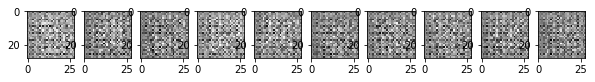

Epochs 0/5: Generator Loss: 4.893. Discriminator Loss: 0.216
Epochs 0/5: Generator Loss: 5.053. Discriminator Loss: 0.19
Epochs 0/5: Generator Loss: 5.129. Discriminator Loss: 0.199
Epochs 0/5: Generator Loss: 5.309. Discriminator Loss: 0.161
Epochs 0/5: Generator Loss: 5.176. Discriminator Loss: 0.214
Epochs 0/5: Generator Loss: 5.397. Discriminator Loss: 0.158
Epochs 0/5: Generator Loss: 5.324. Discriminator Loss: 0.179
Epochs 0/5: Generator Loss: 5.386. Discriminator Loss: 0.156
Epochs 0/5: Generator Loss: 5.143. Discriminator Loss: 0.178
Epochs 0/5: Generator Loss: 5.232. Discriminator Loss: 0.167


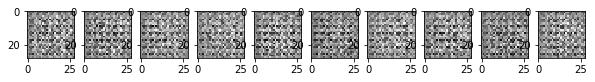

Epochs 0/5: Generator Loss: 5.094. Discriminator Loss: 0.199
Epochs 0/5: Generator Loss: 5.31. Discriminator Loss: 0.175
Epochs 0/5: Generator Loss: 5.554. Discriminator Loss: 0.139
Epochs 0/5: Generator Loss: 5.375. Discriminator Loss: 0.16
Epochs 0/5: Generator Loss: 5.267. Discriminator Loss: 0.178
Epochs 0/5: Generator Loss: 5.563. Discriminator Loss: 0.145
Epochs 0/5: Generator Loss: 5.297. Discriminator Loss: 0.205
Epochs 0/5: Generator Loss: 5.466. Discriminator Loss: 0.154
Epochs 0/5: Generator Loss: 5.427. Discriminator Loss: 0.175
Epochs 0/5: Generator Loss: 5.586. Discriminator Loss: 0.149


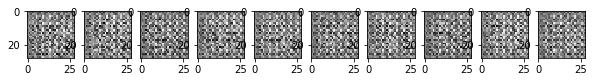

Epochs 0/5: Generator Loss: 5.819. Discriminator Loss: 0.141
Epochs 0/5: Generator Loss: 5.518. Discriminator Loss: 0.156
Epochs 0/5: Generator Loss: 5.361. Discriminator Loss: 0.237
Epochs 0/5: Generator Loss: 5.906. Discriminator Loss: 0.152
Epochs 0/5: Generator Loss: 6.025. Discriminator Loss: 0.124
Epochs 0/5: Generator Loss: 5.976. Discriminator Loss: 0.135
Epochs 0/5: Generator Loss: 5.823. Discriminator Loss: 0.12
Epochs 0/5: Generator Loss: 5.853. Discriminator Loss: 0.131
Epochs 0/5: Generator Loss: 5.663. Discriminator Loss: 0.136
Epochs 0/5: Generator Loss: 5.815. Discriminator Loss: 0.153


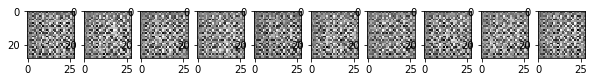

Epochs 0/5: Generator Loss: 6.148. Discriminator Loss: 0.125
Epochs 0/5: Generator Loss: 5.424. Discriminator Loss: 0.186
Epochs 0/5: Generator Loss: 6.113. Discriminator Loss: 0.127
Epochs 0/5: Generator Loss: 5.671. Discriminator Loss: 0.13
Epochs 0/5: Generator Loss: 6.521. Discriminator Loss: 0.097
Epochs 0/5: Generator Loss: 6.331. Discriminator Loss: 0.101
Epochs 0/5: Generator Loss: 6.115. Discriminator Loss: 0.114
Epochs 0/5: Generator Loss: 5.999. Discriminator Loss: 0.119
Epochs 0/5: Generator Loss: 6.033. Discriminator Loss: 0.11
Epochs 0/5: Generator Loss: 6.445. Discriminator Loss: 0.094


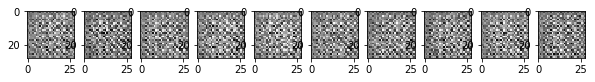

Epochs 0/5: Generator Loss: 6.531. Discriminator Loss: 0.093
Epochs 0/5: Generator Loss: 6.402. Discriminator Loss: 0.147
Epochs 0/5: Generator Loss: 6.693. Discriminator Loss: 0.111
Epochs 0/5: Generator Loss: 6.63. Discriminator Loss: 0.088
Epochs 0/5: Generator Loss: 7.093. Discriminator Loss: 0.07
Epochs 0/5: Generator Loss: 6.896. Discriminator Loss: 0.069
Epochs 0/5: Generator Loss: 6.385. Discriminator Loss: 0.138
Epochs 0/5: Generator Loss: 6.564. Discriminator Loss: 0.101
Epochs 0/5: Generator Loss: 6.484. Discriminator Loss: 0.096
Epochs 0/5: Generator Loss: 6.57. Discriminator Loss: 0.097


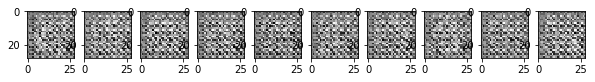

Epochs 0/5: Generator Loss: 6.269. Discriminator Loss: 0.136
Epochs 0/5: Generator Loss: 6.089. Discriminator Loss: 0.158
Epochs 0/5: Generator Loss: 6.457. Discriminator Loss: 0.1
Epochs 0/5: Generator Loss: 6.376. Discriminator Loss: 0.119
Epochs 0/5: Generator Loss: 6.481. Discriminator Loss: 0.105
Epochs 0/5: Generator Loss: 6.502. Discriminator Loss: 0.126
Epochs 0/5: Generator Loss: 5.771. Discriminator Loss: 0.142
Epochs 0/5: Generator Loss: 6.088. Discriminator Loss: 0.164
Epochs 0/5: Generator Loss: 6.249. Discriminator Loss: 0.121
Epochs 0/5: Generator Loss: 5.994. Discriminator Loss: 0.123


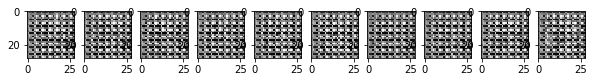

Epochs 0/5: Generator Loss: 5.596. Discriminator Loss: 0.256
Epochs 0/5: Generator Loss: 6.438. Discriminator Loss: 0.164
Epochs 0/5: Generator Loss: 6.775. Discriminator Loss: 0.123
Epochs 0/5: Generator Loss: 6.986. Discriminator Loss: 0.078
Epochs 0/5: Generator Loss: 6.59. Discriminator Loss: 0.103
Epochs 0/5: Generator Loss: 7.054. Discriminator Loss: 0.085
Epochs 0/5: Generator Loss: 7.363. Discriminator Loss: 0.076
Epochs 0/5: Generator Loss: 6.337. Discriminator Loss: 0.127
Epochs 0/5: Generator Loss: 6.243. Discriminator Loss: 0.128
Epochs 0/5: Generator Loss: 6.882. Discriminator Loss: 0.109


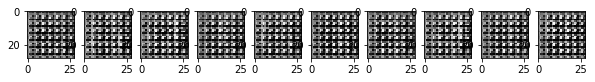

Epochs 0/5: Generator Loss: 7.084. Discriminator Loss: 0.083
Epochs 0/5: Generator Loss: 6.574. Discriminator Loss: 0.288
Epochs 0/5: Generator Loss: 6.617. Discriminator Loss: 0.105
Epochs 0/5: Generator Loss: 6.345. Discriminator Loss: 0.193
Epochs 0/5: Generator Loss: 5.777. Discriminator Loss: 0.196
Epochs 0/5: Generator Loss: 5.83. Discriminator Loss: 0.28
Epochs 0/5: Generator Loss: 6.669. Discriminator Loss: 0.248
Epochs 0/5: Generator Loss: 6.619. Discriminator Loss: 0.098
Epochs 0/5: Generator Loss: 6.554. Discriminator Loss: 0.12
Epochs 0/5: Generator Loss: 6.295. Discriminator Loss: 0.136


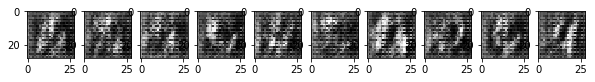

Epochs 0/5: Generator Loss: 6.456. Discriminator Loss: 0.126
Epochs 0/5: Generator Loss: 6.623. Discriminator Loss: 0.106
Epochs 0/5: Generator Loss: 6.343. Discriminator Loss: 0.122
Epochs 0/5: Generator Loss: 6.337. Discriminator Loss: 0.371
Epochs 0/5: Generator Loss: 6.891. Discriminator Loss: 0.094
Epochs 0/5: Generator Loss: 5.837. Discriminator Loss: 0.136
Epochs 0/5: Generator Loss: 6.305. Discriminator Loss: 0.113
Epochs 0/5: Generator Loss: 6.538. Discriminator Loss: 0.103
Epochs 0/5: Generator Loss: 6.342. Discriminator Loss: 0.587
Epochs 0/5: Generator Loss: 7.164. Discriminator Loss: 0.1


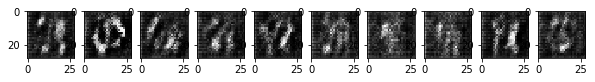

Epochs 0/5: Generator Loss: 6.504. Discriminator Loss: 0.105
Epochs 0/5: Generator Loss: 5.831. Discriminator Loss: 0.138
Epochs 0/5: Generator Loss: 5.878. Discriminator Loss: 0.165
Epochs 0/5: Generator Loss: 6.305. Discriminator Loss: 0.138
Epochs 0/5: Generator Loss: 5.925. Discriminator Loss: 0.132
Epochs 0/5: Generator Loss: 5.899. Discriminator Loss: 0.161
Epochs 0/5: Generator Loss: 6.096. Discriminator Loss: 0.123
Epochs 0/5: Generator Loss: 6.089. Discriminator Loss: 0.15
Epochs 0/5: Generator Loss: 6.125. Discriminator Loss: 0.181
Epochs 0/5: Generator Loss: 6.37. Discriminator Loss: 0.112


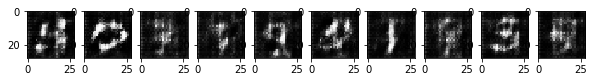

Epochs 0/5: Generator Loss: 6.603. Discriminator Loss: 0.096
Epochs 0/5: Generator Loss: 6.037. Discriminator Loss: 0.16
Epochs 0/5: Generator Loss: 6.723. Discriminator Loss: 0.146
Epochs 0/5: Generator Loss: 6.274. Discriminator Loss: 0.121
Epochs 0/5: Generator Loss: 5.912. Discriminator Loss: 0.126
Epochs 0/5: Generator Loss: 6.211. Discriminator Loss: 0.11
Epochs 0/5: Generator Loss: 6.024. Discriminator Loss: 0.126
Epochs 0/5: Generator Loss: 5.839. Discriminator Loss: 0.155
Epochs 0/5: Generator Loss: 6.325. Discriminator Loss: 0.119
Epochs 0/5: Generator Loss: 6.395. Discriminator Loss: 0.109


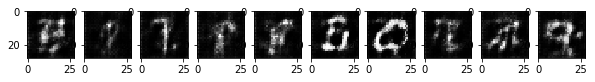

Epochs 0/5: Generator Loss: 6.356. Discriminator Loss: 0.122
Epochs 0/5: Generator Loss: 5.44. Discriminator Loss: 0.181
Epochs 0/5: Generator Loss: 6.964. Discriminator Loss: 0.124
Epochs 0/5: Generator Loss: 6.866. Discriminator Loss: 0.106
Epochs 0/5: Generator Loss: 6.744. Discriminator Loss: 0.101
Epochs 0/5: Generator Loss: 6.355. Discriminator Loss: 0.114
Epochs 0/5: Generator Loss: 6.562. Discriminator Loss: 0.098
Epochs 0/5: Generator Loss: 5.784. Discriminator Loss: 0.149
Epochs 0/5: Generator Loss: 6.288. Discriminator Loss: 0.117
Epochs 0/5: Generator Loss: 6.642. Discriminator Loss: 0.118


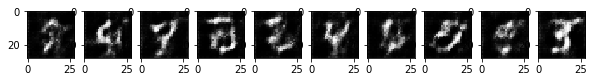

Epochs 0/5: Generator Loss: 6.628. Discriminator Loss: 0.102
Epochs 0/5: Generator Loss: 6.938. Discriminator Loss: 0.08
Epochs 0/5: Generator Loss: 6.255. Discriminator Loss: 0.111
Epochs 0/5: Generator Loss: 7.138. Discriminator Loss: 0.09
Epochs 0/5: Generator Loss: 6.68. Discriminator Loss: 0.111
Epochs 0/5: Generator Loss: 7.142. Discriminator Loss: 0.112
Epochs 0/5: Generator Loss: 6.597. Discriminator Loss: 0.121
Epochs 0/5: Generator Loss: 5.977. Discriminator Loss: 0.144
Epochs 0/5: Generator Loss: 6.293. Discriminator Loss: 0.107
Epochs 0/5: Generator Loss: 6.644. Discriminator Loss: 0.096


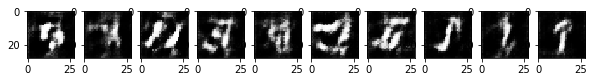

Epochs 0/5: Generator Loss: 6.213. Discriminator Loss: 0.289
Epochs 0/5: Generator Loss: 7.683. Discriminator Loss: 0.068
Epochs 0/5: Generator Loss: 6.406. Discriminator Loss: 0.133
Epochs 0/5: Generator Loss: 6.8. Discriminator Loss: 0.112
Epochs 0/5: Generator Loss: 6.866. Discriminator Loss: 0.121
Epochs 0/5: Generator Loss: 6.769. Discriminator Loss: 0.099
Epochs 0/5: Generator Loss: 7.181. Discriminator Loss: 0.095
Epochs 0/5: Generator Loss: 6.503. Discriminator Loss: 0.1
Epochs 0/5: Generator Loss: 6.279. Discriminator Loss: 0.145
Epochs 0/5: Generator Loss: 7.341. Discriminator Loss: 0.127


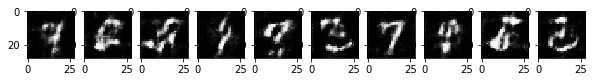

Epochs 0/5: Generator Loss: 7.087. Discriminator Loss: 0.096
Epochs 0/5: Generator Loss: 6.752. Discriminator Loss: 0.106
Epochs 0/5: Generator Loss: 6.801. Discriminator Loss: 0.102
Epochs 0/5: Generator Loss: 6.643. Discriminator Loss: 0.112
Epochs 0/5: Generator Loss: 6.518. Discriminator Loss: 0.118
Epochs 0/5: Generator Loss: 6.685. Discriminator Loss: 0.099
Epochs 0/5: Generator Loss: 6.626. Discriminator Loss: 0.117
Epochs 0/5: Generator Loss: 5.981. Discriminator Loss: 0.147
Epochs 0/5: Generator Loss: 6.822. Discriminator Loss: 0.137
Epochs 0/5: Generator Loss: 6.03. Discriminator Loss: 0.18


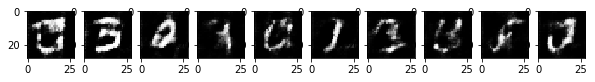

Epochs 0/5: Generator Loss: 6.51. Discriminator Loss: 0.105
Epochs 0/5: Generator Loss: 6.072. Discriminator Loss: 0.175
Epochs 0/5: Generator Loss: 6.595. Discriminator Loss: 0.092
Epochs 0/5: Generator Loss: 6.139. Discriminator Loss: 0.152
Epochs 0/5: Generator Loss: 6.706. Discriminator Loss: 0.114
Epochs 0/5: Generator Loss: 6.666. Discriminator Loss: 0.103
Epochs 0/5: Generator Loss: 6.172. Discriminator Loss: 0.154
Epochs 0/5: Generator Loss: 6.237. Discriminator Loss: 0.124
Epochs 0/5: Generator Loss: 6.562. Discriminator Loss: 0.123
Epochs 0/5: Generator Loss: 5.8. Discriminator Loss: 0.203


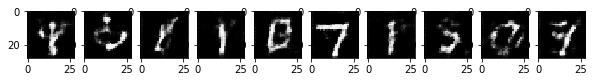

Epochs 0/5: Generator Loss: 7.071. Discriminator Loss: 0.085
Epochs 0/5: Generator Loss: 5.57. Discriminator Loss: 0.172
Epochs 0/5: Generator Loss: 6.115. Discriminator Loss: 0.216
Epochs 0/5: Generator Loss: 6.546. Discriminator Loss: 0.118
Epochs 0/5: Generator Loss: 6.456. Discriminator Loss: 0.167
Epochs 0/5: Generator Loss: 6.916. Discriminator Loss: 0.107
Epochs 0/5: Generator Loss: 6.16. Discriminator Loss: 0.243
Epochs 1/5: Generator Loss: 6.7. Discriminator Loss: 0.138
Epochs 1/5: Generator Loss: 5.853. Discriminator Loss: 0.139
Epochs 1/5: Generator Loss: 6.264. Discriminator Loss: 0.113


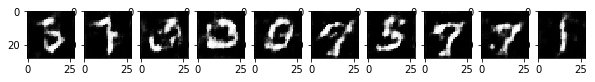

Epochs 1/5: Generator Loss: 5.801. Discriminator Loss: 0.141
Epochs 1/5: Generator Loss: 6.738. Discriminator Loss: 0.097
Epochs 1/5: Generator Loss: 6.048. Discriminator Loss: 0.127
Epochs 1/5: Generator Loss: 6.512. Discriminator Loss: 0.105
Epochs 1/5: Generator Loss: 6.069. Discriminator Loss: 0.162
Epochs 1/5: Generator Loss: 6.272. Discriminator Loss: 0.121
Epochs 1/5: Generator Loss: 6.367. Discriminator Loss: 0.172
Epochs 1/5: Generator Loss: 6.341. Discriminator Loss: 0.13
Epochs 1/5: Generator Loss: 7.293. Discriminator Loss: 0.097
Epochs 1/5: Generator Loss: 5.852. Discriminator Loss: 0.158


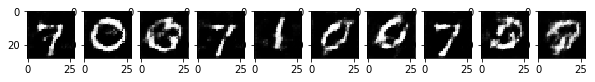

Epochs 1/5: Generator Loss: 6.534. Discriminator Loss: 0.113
Epochs 1/5: Generator Loss: 5.889. Discriminator Loss: 0.17
Epochs 1/5: Generator Loss: 6.695. Discriminator Loss: 0.105
Epochs 1/5: Generator Loss: 7.408. Discriminator Loss: 0.081
Epochs 1/5: Generator Loss: 5.976. Discriminator Loss: 0.167
Epochs 1/5: Generator Loss: 6.829. Discriminator Loss: 0.114
Epochs 1/5: Generator Loss: 7.015. Discriminator Loss: 0.094
Epochs 1/5: Generator Loss: 6.555. Discriminator Loss: 0.138
Epochs 1/5: Generator Loss: 7.079. Discriminator Loss: 0.107
Epochs 1/5: Generator Loss: 6.657. Discriminator Loss: 0.108


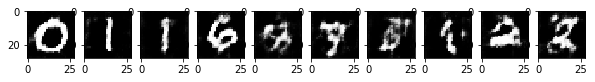

Epochs 1/5: Generator Loss: 7.052. Discriminator Loss: 0.121
Epochs 1/5: Generator Loss: 7.206. Discriminator Loss: 0.082
Epochs 1/5: Generator Loss: 6.761. Discriminator Loss: 0.106
Epochs 1/5: Generator Loss: 7.044. Discriminator Loss: 0.085
Epochs 1/5: Generator Loss: 5.641. Discriminator Loss: 0.211
Epochs 1/5: Generator Loss: 6.535. Discriminator Loss: 0.115
Epochs 1/5: Generator Loss: 6.572. Discriminator Loss: 0.096
Epochs 1/5: Generator Loss: 6.354. Discriminator Loss: 0.124
Epochs 1/5: Generator Loss: 6.951. Discriminator Loss: 0.105
Epochs 1/5: Generator Loss: 7.05. Discriminator Loss: 0.078


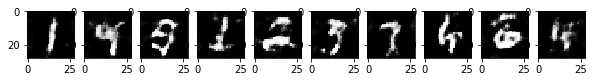

Epochs 1/5: Generator Loss: 6.965. Discriminator Loss: 0.102
Epochs 1/5: Generator Loss: 6.551. Discriminator Loss: 0.104
Epochs 1/5: Generator Loss: 6.853. Discriminator Loss: 0.108
Epochs 1/5: Generator Loss: 6.364. Discriminator Loss: 0.123
Epochs 1/5: Generator Loss: 6.992. Discriminator Loss: 0.087
Epochs 1/5: Generator Loss: 7.069. Discriminator Loss: 0.093
Epochs 1/5: Generator Loss: 6.582. Discriminator Loss: 0.156
Epochs 1/5: Generator Loss: 6.812. Discriminator Loss: 0.129
Epochs 1/5: Generator Loss: 7.403. Discriminator Loss: 0.089
Epochs 1/5: Generator Loss: 7.145. Discriminator Loss: 0.113


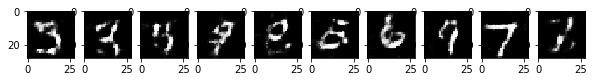

Epochs 1/5: Generator Loss: 7.477. Discriminator Loss: 0.096
Epochs 1/5: Generator Loss: 7.777. Discriminator Loss: 0.087
Epochs 1/5: Generator Loss: 7.403. Discriminator Loss: 0.109
Epochs 1/5: Generator Loss: 7.212. Discriminator Loss: 0.098
Epochs 1/5: Generator Loss: 7.217. Discriminator Loss: 0.105
Epochs 1/5: Generator Loss: 6.904. Discriminator Loss: 0.195
Epochs 1/5: Generator Loss: 7.068. Discriminator Loss: 0.119
Epochs 1/5: Generator Loss: 7.124. Discriminator Loss: 0.11
Epochs 1/5: Generator Loss: 5.772. Discriminator Loss: 0.176
Epochs 1/5: Generator Loss: 6.847. Discriminator Loss: 0.108


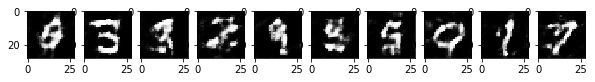

Epochs 1/5: Generator Loss: 6.74. Discriminator Loss: 0.148
Epochs 1/5: Generator Loss: 6.24. Discriminator Loss: 0.142
Epochs 1/5: Generator Loss: 6.463. Discriminator Loss: 0.169
Epochs 1/5: Generator Loss: 6.926. Discriminator Loss: 0.099
Epochs 1/5: Generator Loss: 6.661. Discriminator Loss: 0.14
Epochs 1/5: Generator Loss: 6.89. Discriminator Loss: 0.111
Epochs 1/5: Generator Loss: 7.003. Discriminator Loss: 0.082
Epochs 1/5: Generator Loss: 7.202. Discriminator Loss: 0.09
Epochs 1/5: Generator Loss: 7.604. Discriminator Loss: 0.147
Epochs 1/5: Generator Loss: 7.71. Discriminator Loss: 0.085


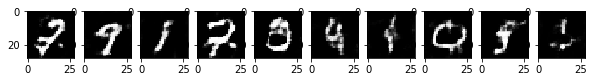

Epochs 1/5: Generator Loss: 7.188. Discriminator Loss: 0.091
Epochs 1/5: Generator Loss: 7.195. Discriminator Loss: 0.099
Epochs 1/5: Generator Loss: 7.141. Discriminator Loss: 0.076
Epochs 1/5: Generator Loss: 6.141. Discriminator Loss: 0.197
Epochs 1/5: Generator Loss: 7.412. Discriminator Loss: 0.095
Epochs 1/5: Generator Loss: 6.863. Discriminator Loss: 0.143
Epochs 1/5: Generator Loss: 7.225. Discriminator Loss: 0.098
Epochs 1/5: Generator Loss: 7.203. Discriminator Loss: 0.086
Epochs 1/5: Generator Loss: 6.734. Discriminator Loss: 0.12
Epochs 1/5: Generator Loss: 6.971. Discriminator Loss: 0.1


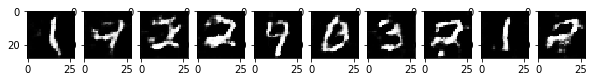

Epochs 1/5: Generator Loss: 7.219. Discriminator Loss: 0.091
Epochs 1/5: Generator Loss: 6.792. Discriminator Loss: 0.095
Epochs 1/5: Generator Loss: 6.804. Discriminator Loss: 0.12
Epochs 1/5: Generator Loss: 7.877. Discriminator Loss: 0.068
Epochs 1/5: Generator Loss: 6.879. Discriminator Loss: 0.137
Epochs 1/5: Generator Loss: 7.08. Discriminator Loss: 0.111
Epochs 1/5: Generator Loss: 7.355. Discriminator Loss: 0.102
Epochs 1/5: Generator Loss: 6.937. Discriminator Loss: 0.083
Epochs 1/5: Generator Loss: 7.049. Discriminator Loss: 0.141
Epochs 1/5: Generator Loss: 6.617. Discriminator Loss: 0.101


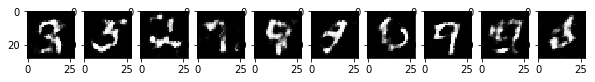

Epochs 1/5: Generator Loss: 7.495. Discriminator Loss: 0.077
Epochs 1/5: Generator Loss: 7.692. Discriminator Loss: 0.087
Epochs 1/5: Generator Loss: 7.271. Discriminator Loss: 0.099
Epochs 1/5: Generator Loss: 7.015. Discriminator Loss: 0.11
Epochs 1/5: Generator Loss: 6.852. Discriminator Loss: 0.118
Epochs 1/5: Generator Loss: 7.411. Discriminator Loss: 0.077
Epochs 1/5: Generator Loss: 6.973. Discriminator Loss: 0.125
Epochs 1/5: Generator Loss: 6.571. Discriminator Loss: 0.106
Epochs 1/5: Generator Loss: 6.022. Discriminator Loss: 0.176
Epochs 1/5: Generator Loss: 7.641. Discriminator Loss: 0.121


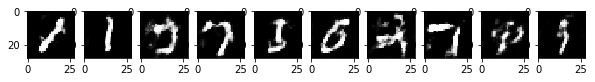

Epochs 1/5: Generator Loss: 6.886. Discriminator Loss: 0.126
Epochs 1/5: Generator Loss: 7.201. Discriminator Loss: 0.115
Epochs 1/5: Generator Loss: 7.012. Discriminator Loss: 0.099
Epochs 1/5: Generator Loss: 7.042. Discriminator Loss: 0.089
Epochs 1/5: Generator Loss: 7.244. Discriminator Loss: 0.081
Epochs 1/5: Generator Loss: 6.859. Discriminator Loss: 0.145
Epochs 1/5: Generator Loss: 7.163. Discriminator Loss: 0.128
Epochs 1/5: Generator Loss: 7.605. Discriminator Loss: 0.077
Epochs 1/5: Generator Loss: 7.212. Discriminator Loss: 0.098
Epochs 1/5: Generator Loss: 7.116. Discriminator Loss: 0.101


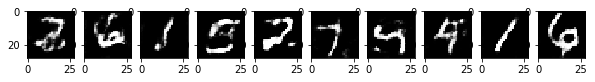

Epochs 1/5: Generator Loss: 6.661. Discriminator Loss: 0.161
Epochs 1/5: Generator Loss: 6.759. Discriminator Loss: 0.121
Epochs 1/5: Generator Loss: 6.557. Discriminator Loss: 0.143
Epochs 1/5: Generator Loss: 7.219. Discriminator Loss: 0.076
Epochs 1/5: Generator Loss: 6.542. Discriminator Loss: 0.12
Epochs 1/5: Generator Loss: 6.982. Discriminator Loss: 0.084
Epochs 1/5: Generator Loss: 7.908. Discriminator Loss: 0.088
Epochs 1/5: Generator Loss: 7.303. Discriminator Loss: 0.104
Epochs 1/5: Generator Loss: 6.603. Discriminator Loss: 0.108
Epochs 1/5: Generator Loss: 6.547. Discriminator Loss: 0.132


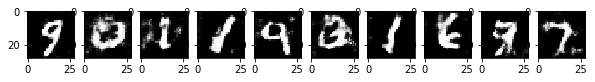

Epochs 1/5: Generator Loss: 6.393. Discriminator Loss: 0.149
Epochs 1/5: Generator Loss: 6.316. Discriminator Loss: 0.143
Epochs 1/5: Generator Loss: 7.264. Discriminator Loss: 0.085
Epochs 1/5: Generator Loss: 7.083. Discriminator Loss: 0.093
Epochs 1/5: Generator Loss: 7.329. Discriminator Loss: 0.083
Epochs 1/5: Generator Loss: 7.39. Discriminator Loss: 0.106
Epochs 1/5: Generator Loss: 7.304. Discriminator Loss: 0.086
Epochs 1/5: Generator Loss: 6.983. Discriminator Loss: 0.114
Epochs 1/5: Generator Loss: 7.622. Discriminator Loss: 0.076
Epochs 1/5: Generator Loss: 7.116. Discriminator Loss: 0.158


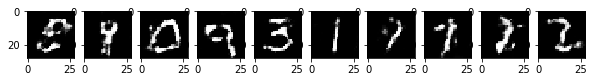

Epochs 1/5: Generator Loss: 7.053. Discriminator Loss: 0.092
Epochs 1/5: Generator Loss: 7.344. Discriminator Loss: 0.09
Epochs 1/5: Generator Loss: 6.662. Discriminator Loss: 0.1
Epochs 1/5: Generator Loss: 6.275. Discriminator Loss: 0.13
Epochs 1/5: Generator Loss: 7.006. Discriminator Loss: 0.098
Epochs 1/5: Generator Loss: 7.433. Discriminator Loss: 0.108
Epochs 1/5: Generator Loss: 6.62. Discriminator Loss: 0.121
Epochs 1/5: Generator Loss: 7.675. Discriminator Loss: 0.079
Epochs 1/5: Generator Loss: 8.178. Discriminator Loss: 0.073
Epochs 1/5: Generator Loss: 7.366. Discriminator Loss: 0.144


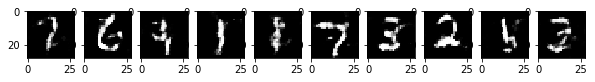

Epochs 1/5: Generator Loss: 7.191. Discriminator Loss: 0.101
Epochs 1/5: Generator Loss: 6.912. Discriminator Loss: 0.166
Epochs 1/5: Generator Loss: 6.646. Discriminator Loss: 0.133
Epochs 1/5: Generator Loss: 7.264. Discriminator Loss: 0.091
Epochs 1/5: Generator Loss: 6.606. Discriminator Loss: 0.116
Epochs 1/5: Generator Loss: 7.405. Discriminator Loss: 0.105
Epochs 1/5: Generator Loss: 7.252. Discriminator Loss: 0.095
Epochs 1/5: Generator Loss: 7.595. Discriminator Loss: 0.087
Epochs 1/5: Generator Loss: 7.394. Discriminator Loss: 0.074
Epochs 1/5: Generator Loss: 7.465. Discriminator Loss: 0.104


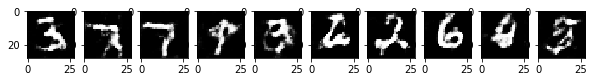

Epochs 1/5: Generator Loss: 7.542. Discriminator Loss: 0.12
Epochs 1/5: Generator Loss: 7.129. Discriminator Loss: 0.088
Epochs 1/5: Generator Loss: 7.6. Discriminator Loss: 0.081
Epochs 1/5: Generator Loss: 7.627. Discriminator Loss: 0.074
Epochs 1/5: Generator Loss: 6.419. Discriminator Loss: 0.158
Epochs 1/5: Generator Loss: 7.304. Discriminator Loss: 0.09
Epochs 1/5: Generator Loss: 7.044. Discriminator Loss: 0.085
Epochs 1/5: Generator Loss: 7.475. Discriminator Loss: 0.092
Epochs 1/5: Generator Loss: 7.831. Discriminator Loss: 0.098
Epochs 1/5: Generator Loss: 8.116. Discriminator Loss: 0.077


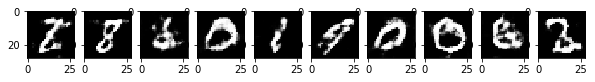

Epochs 1/5: Generator Loss: 7.861. Discriminator Loss: 0.063
Epochs 1/5: Generator Loss: 7.642. Discriminator Loss: 0.084
Epochs 1/5: Generator Loss: 7.037. Discriminator Loss: 0.1
Epochs 1/5: Generator Loss: 7.779. Discriminator Loss: 0.069
Epochs 1/5: Generator Loss: 7.71. Discriminator Loss: 0.179
Epochs 1/5: Generator Loss: 7.041. Discriminator Loss: 0.098
Epochs 1/5: Generator Loss: 7.436. Discriminator Loss: 0.085
Epochs 1/5: Generator Loss: 7.496. Discriminator Loss: 0.087
Epochs 1/5: Generator Loss: 8.121. Discriminator Loss: 0.083
Epochs 1/5: Generator Loss: 7.633. Discriminator Loss: 0.1


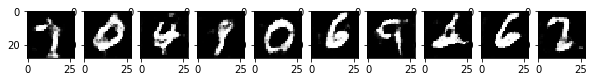

Epochs 1/5: Generator Loss: 7.828. Discriminator Loss: 0.073
Epochs 1/5: Generator Loss: 7.877. Discriminator Loss: 0.059
Epochs 1/5: Generator Loss: 7.832. Discriminator Loss: 0.074
Epochs 1/5: Generator Loss: 7.561. Discriminator Loss: 0.1
Epochs 1/5: Generator Loss: 8.177. Discriminator Loss: 0.064
Epochs 1/5: Generator Loss: 8.312. Discriminator Loss: 0.063
Epochs 1/5: Generator Loss: 7.192. Discriminator Loss: 0.108
Epochs 1/5: Generator Loss: 7.192. Discriminator Loss: 0.103
Epochs 1/5: Generator Loss: 7.489. Discriminator Loss: 0.085
Epochs 1/5: Generator Loss: 6.962. Discriminator Loss: 0.129


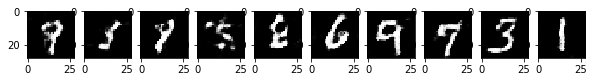

Epochs 1/5: Generator Loss: 6.856. Discriminator Loss: 0.094
Epochs 1/5: Generator Loss: 8.006. Discriminator Loss: 0.083
Epochs 1/5: Generator Loss: 7.036. Discriminator Loss: 0.092
Epochs 1/5: Generator Loss: 7.489. Discriminator Loss: 0.266
Epochs 1/5: Generator Loss: 7.86. Discriminator Loss: 0.072
Epochs 1/5: Generator Loss: 7.486. Discriminator Loss: 0.103
Epochs 1/5: Generator Loss: 7.18. Discriminator Loss: 0.081
Epochs 1/5: Generator Loss: 7.444. Discriminator Loss: 0.103
Epochs 1/5: Generator Loss: 8.068. Discriminator Loss: 0.066
Epochs 1/5: Generator Loss: 7.786. Discriminator Loss: 0.101


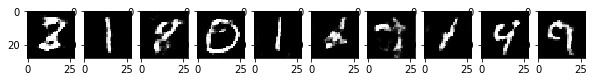

Epochs 1/5: Generator Loss: 7.01. Discriminator Loss: 0.115
Epochs 1/5: Generator Loss: 7.408. Discriminator Loss: 0.125
Epochs 1/5: Generator Loss: 7.575. Discriminator Loss: 0.074
Epochs 1/5: Generator Loss: 6.629. Discriminator Loss: 0.113
Epochs 2/5: Generator Loss: 4.701. Discriminator Loss: 0.658
Epochs 2/5: Generator Loss: 7.06. Discriminator Loss: 0.089
Epochs 2/5: Generator Loss: 7.002. Discriminator Loss: 0.095
Epochs 2/5: Generator Loss: 6.593. Discriminator Loss: 0.12
Epochs 2/5: Generator Loss: 7.25. Discriminator Loss: 0.08
Epochs 2/5: Generator Loss: 6.858. Discriminator Loss: 0.096


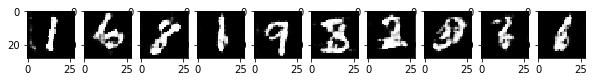

Epochs 2/5: Generator Loss: 7.048. Discriminator Loss: 0.102
Epochs 2/5: Generator Loss: 7.661. Discriminator Loss: 0.069
Epochs 2/5: Generator Loss: 6.922. Discriminator Loss: 0.103
Epochs 2/5: Generator Loss: 7.27. Discriminator Loss: 0.096
Epochs 2/5: Generator Loss: 7.171. Discriminator Loss: 0.108
Epochs 2/5: Generator Loss: 8.055. Discriminator Loss: 0.067
Epochs 2/5: Generator Loss: 7.689. Discriminator Loss: 0.097
Epochs 2/5: Generator Loss: 6.695. Discriminator Loss: 0.109
Epochs 2/5: Generator Loss: 7.297. Discriminator Loss: 0.091
Epochs 2/5: Generator Loss: 7.975. Discriminator Loss: 0.075


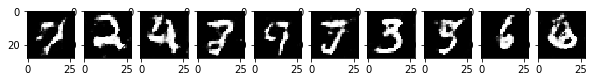

Epochs 2/5: Generator Loss: 7.453. Discriminator Loss: 0.078
Epochs 2/5: Generator Loss: 7.547. Discriminator Loss: 0.095
Epochs 2/5: Generator Loss: 8.349. Discriminator Loss: 0.074
Epochs 2/5: Generator Loss: 8.358. Discriminator Loss: 0.093
Epochs 2/5: Generator Loss: 8.341. Discriminator Loss: 0.07
Epochs 2/5: Generator Loss: 7.315. Discriminator Loss: 0.106
Epochs 2/5: Generator Loss: 7.719. Discriminator Loss: 0.068
Epochs 2/5: Generator Loss: 7.463. Discriminator Loss: 0.099
Epochs 2/5: Generator Loss: 8.28. Discriminator Loss: 0.052
Epochs 2/5: Generator Loss: 7.85. Discriminator Loss: 0.085


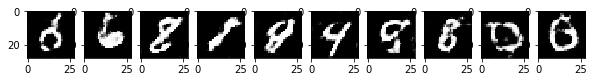

Epochs 2/5: Generator Loss: 7.761. Discriminator Loss: 0.096
Epochs 2/5: Generator Loss: 7.755. Discriminator Loss: 0.089
Epochs 2/5: Generator Loss: 7.779. Discriminator Loss: 0.066
Epochs 2/5: Generator Loss: 7.433. Discriminator Loss: 0.079
Epochs 2/5: Generator Loss: 7.517. Discriminator Loss: 0.076
Epochs 2/5: Generator Loss: 7.174. Discriminator Loss: 0.09
Epochs 2/5: Generator Loss: 7.247. Discriminator Loss: 0.091
Epochs 2/5: Generator Loss: 7.913. Discriminator Loss: 0.071
Epochs 2/5: Generator Loss: 7.507. Discriminator Loss: 0.087
Epochs 2/5: Generator Loss: 7.184. Discriminator Loss: 0.109


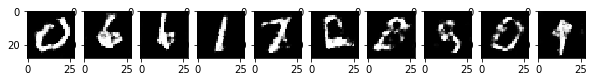

Epochs 2/5: Generator Loss: 8.672. Discriminator Loss: 0.048
Epochs 2/5: Generator Loss: 6.961. Discriminator Loss: 0.114
Epochs 2/5: Generator Loss: 7.79. Discriminator Loss: 0.078
Epochs 2/5: Generator Loss: 6.97. Discriminator Loss: 0.11
Epochs 2/5: Generator Loss: 7.955. Discriminator Loss: 0.094
Epochs 2/5: Generator Loss: 8.469. Discriminator Loss: 0.061
Epochs 2/5: Generator Loss: 7.701. Discriminator Loss: 0.072
Epochs 2/5: Generator Loss: 8.134. Discriminator Loss: 0.131
Epochs 2/5: Generator Loss: 8.406. Discriminator Loss: 0.129
Epochs 2/5: Generator Loss: 8.566. Discriminator Loss: 0.072


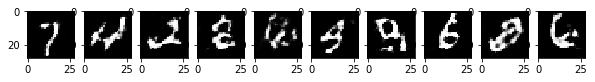

Epochs 2/5: Generator Loss: 8.32. Discriminator Loss: 0.066
Epochs 2/5: Generator Loss: 7.73. Discriminator Loss: 0.078
Epochs 2/5: Generator Loss: 7.783. Discriminator Loss: 0.068
Epochs 2/5: Generator Loss: 7.49. Discriminator Loss: 0.087
Epochs 2/5: Generator Loss: 8.187. Discriminator Loss: 0.083
Epochs 2/5: Generator Loss: 7.619. Discriminator Loss: 0.077
Epochs 2/5: Generator Loss: 7.805. Discriminator Loss: 0.068
Epochs 2/5: Generator Loss: 7.065. Discriminator Loss: 0.081
Epochs 2/5: Generator Loss: 7.187. Discriminator Loss: 0.073
Epochs 2/5: Generator Loss: 8.141. Discriminator Loss: 0.07


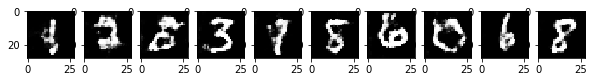

Epochs 2/5: Generator Loss: 7.696. Discriminator Loss: 0.078
Epochs 2/5: Generator Loss: 6.997. Discriminator Loss: 0.095
Epochs 2/5: Generator Loss: 7.92. Discriminator Loss: 0.103
Epochs 2/5: Generator Loss: 8.37. Discriminator Loss: 0.05
Epochs 2/5: Generator Loss: 8.312. Discriminator Loss: 0.057
Epochs 2/5: Generator Loss: 8.467. Discriminator Loss: 0.056
Epochs 2/5: Generator Loss: 8.461. Discriminator Loss: 0.08
Epochs 2/5: Generator Loss: 8.443. Discriminator Loss: 0.049
Epochs 2/5: Generator Loss: 7.623. Discriminator Loss: 0.068
Epochs 2/5: Generator Loss: 8.723. Discriminator Loss: 0.05


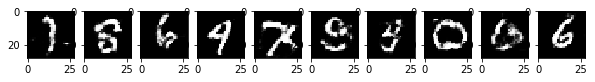

Epochs 2/5: Generator Loss: 8.471. Discriminator Loss: 0.074
Epochs 2/5: Generator Loss: 9.112. Discriminator Loss: 0.048
Epochs 2/5: Generator Loss: 8.904. Discriminator Loss: 0.058
Epochs 2/5: Generator Loss: 8.481. Discriminator Loss: 0.073
Epochs 2/5: Generator Loss: 8.839. Discriminator Loss: 0.049
Epochs 2/5: Generator Loss: 8.807. Discriminator Loss: 0.068
Epochs 2/5: Generator Loss: 8.714. Discriminator Loss: 0.068
Epochs 2/5: Generator Loss: 8.534. Discriminator Loss: 0.09
Epochs 2/5: Generator Loss: 8.659. Discriminator Loss: 0.065
Epochs 2/5: Generator Loss: 8.153. Discriminator Loss: 0.064


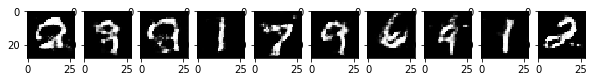

Epochs 2/5: Generator Loss: 8.887. Discriminator Loss: 0.104
Epochs 2/5: Generator Loss: 8.435. Discriminator Loss: 0.061
Epochs 2/5: Generator Loss: 8.04. Discriminator Loss: 0.146
Epochs 2/5: Generator Loss: 8.461. Discriminator Loss: 0.077
Epochs 2/5: Generator Loss: 8.201. Discriminator Loss: 0.064
Epochs 2/5: Generator Loss: 7.58. Discriminator Loss: 0.073
Epochs 2/5: Generator Loss: 8.775. Discriminator Loss: 0.072
Epochs 2/5: Generator Loss: 8.747. Discriminator Loss: 0.092
Epochs 2/5: Generator Loss: 9.406. Discriminator Loss: 0.051
Epochs 2/5: Generator Loss: 8.566. Discriminator Loss: 0.069


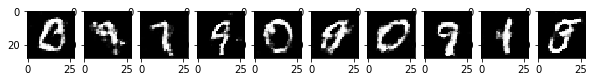

Epochs 2/5: Generator Loss: 8.439. Discriminator Loss: 0.067
Epochs 2/5: Generator Loss: 8.546. Discriminator Loss: 0.061
Epochs 2/5: Generator Loss: 8.014. Discriminator Loss: 0.071
Epochs 2/5: Generator Loss: 8.484. Discriminator Loss: 0.068
Epochs 2/5: Generator Loss: 8.328. Discriminator Loss: 0.048
Epochs 2/5: Generator Loss: 8.684. Discriminator Loss: 0.067
Epochs 2/5: Generator Loss: 8.884. Discriminator Loss: 0.083
Epochs 2/5: Generator Loss: 9.102. Discriminator Loss: 0.051
Epochs 2/5: Generator Loss: 8.581. Discriminator Loss: 0.081
Epochs 2/5: Generator Loss: 8.325. Discriminator Loss: 0.047


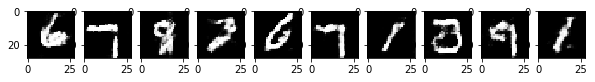

Epochs 2/5: Generator Loss: 7.922. Discriminator Loss: 0.063
Epochs 2/5: Generator Loss: 8.39. Discriminator Loss: 0.066
Epochs 2/5: Generator Loss: 8.808. Discriminator Loss: 0.06
Epochs 2/5: Generator Loss: 8.359. Discriminator Loss: 0.073
Epochs 2/5: Generator Loss: 8.987. Discriminator Loss: 0.06
Epochs 2/5: Generator Loss: 7.914. Discriminator Loss: 0.094
Epochs 2/5: Generator Loss: 8.143. Discriminator Loss: 0.055
Epochs 2/5: Generator Loss: 8.246. Discriminator Loss: 0.069
Epochs 2/5: Generator Loss: 8.121. Discriminator Loss: 0.08
Epochs 2/5: Generator Loss: 9.487. Discriminator Loss: 0.038


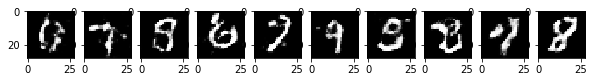

Epochs 2/5: Generator Loss: 8.222. Discriminator Loss: 0.055
Epochs 2/5: Generator Loss: 7.997. Discriminator Loss: 0.062
Epochs 2/5: Generator Loss: 9.152. Discriminator Loss: 0.038
Epochs 2/5: Generator Loss: 7.916. Discriminator Loss: 0.074
Epochs 2/5: Generator Loss: 9.079. Discriminator Loss: 0.037
Epochs 2/5: Generator Loss: 8.057. Discriminator Loss: 0.069
Epochs 2/5: Generator Loss: 7.723. Discriminator Loss: 0.056
Epochs 2/5: Generator Loss: 8.795. Discriminator Loss: 0.051
Epochs 2/5: Generator Loss: 8.657. Discriminator Loss: 0.055
Epochs 2/5: Generator Loss: 7.956. Discriminator Loss: 0.09


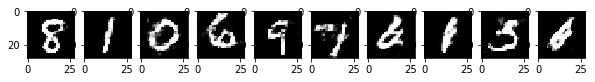

Epochs 2/5: Generator Loss: 8.601. Discriminator Loss: 0.052
Epochs 2/5: Generator Loss: 8.539. Discriminator Loss: 0.046
Epochs 2/5: Generator Loss: 8.278. Discriminator Loss: 0.085
Epochs 2/5: Generator Loss: 8.525. Discriminator Loss: 0.094
Epochs 2/5: Generator Loss: 8.717. Discriminator Loss: 0.059
Epochs 2/5: Generator Loss: 8.64. Discriminator Loss: 0.052
Epochs 2/5: Generator Loss: 7.49. Discriminator Loss: 0.076
Epochs 2/5: Generator Loss: 9.399. Discriminator Loss: 0.072
Epochs 2/5: Generator Loss: 8.62. Discriminator Loss: 0.065
Epochs 2/5: Generator Loss: 7.993. Discriminator Loss: 0.057


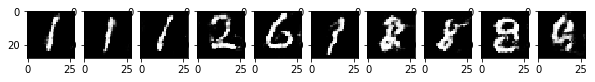

Epochs 2/5: Generator Loss: 8.908. Discriminator Loss: 0.047
Epochs 2/5: Generator Loss: 8.365. Discriminator Loss: 0.063
Epochs 2/5: Generator Loss: 7.939. Discriminator Loss: 0.07
Epochs 2/5: Generator Loss: 8.021. Discriminator Loss: 0.057
Epochs 2/5: Generator Loss: 8.185. Discriminator Loss: 0.059
Epochs 2/5: Generator Loss: 8.892. Discriminator Loss: 0.05
Epochs 2/5: Generator Loss: 8.21. Discriminator Loss: 0.1
Epochs 2/5: Generator Loss: 8.568. Discriminator Loss: 0.069
Epochs 2/5: Generator Loss: 8.665. Discriminator Loss: 0.062
Epochs 2/5: Generator Loss: 8.274. Discriminator Loss: 0.066


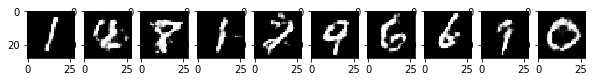

Epochs 2/5: Generator Loss: 7.643. Discriminator Loss: 0.078
Epochs 2/5: Generator Loss: 8.397. Discriminator Loss: 0.053
Epochs 2/5: Generator Loss: 8.341. Discriminator Loss: 0.069
Epochs 2/5: Generator Loss: 8.468. Discriminator Loss: 0.053
Epochs 2/5: Generator Loss: 9.145. Discriminator Loss: 0.05
Epochs 2/5: Generator Loss: 8.868. Discriminator Loss: 0.045
Epochs 2/5: Generator Loss: 8.669. Discriminator Loss: 0.045
Epochs 2/5: Generator Loss: 9.339. Discriminator Loss: 0.051
Epochs 2/5: Generator Loss: 9.593. Discriminator Loss: 0.045
Epochs 2/5: Generator Loss: 8.576. Discriminator Loss: 0.064


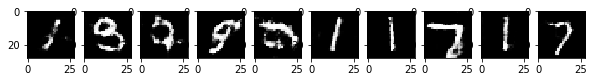

Epochs 2/5: Generator Loss: 9.609. Discriminator Loss: 0.069
Epochs 2/5: Generator Loss: 8.863. Discriminator Loss: 0.05
Epochs 2/5: Generator Loss: 8.66. Discriminator Loss: 0.073
Epochs 2/5: Generator Loss: 8.531. Discriminator Loss: 0.055
Epochs 2/5: Generator Loss: 8.778. Discriminator Loss: 0.047
Epochs 2/5: Generator Loss: 8.422. Discriminator Loss: 0.108
Epochs 2/5: Generator Loss: 9.128. Discriminator Loss: 0.05
Epochs 2/5: Generator Loss: 9.266. Discriminator Loss: 0.053
Epochs 2/5: Generator Loss: 9.018. Discriminator Loss: 0.061
Epochs 2/5: Generator Loss: 8.686. Discriminator Loss: 0.049


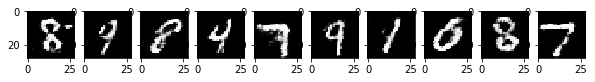

Epochs 2/5: Generator Loss: 8.4. Discriminator Loss: 0.055
Epochs 2/5: Generator Loss: 8.899. Discriminator Loss: 0.043
Epochs 2/5: Generator Loss: 9.768. Discriminator Loss: 0.037
Epochs 2/5: Generator Loss: 9.407. Discriminator Loss: 0.065
Epochs 2/5: Generator Loss: 9.646. Discriminator Loss: 0.045
Epochs 2/5: Generator Loss: 8.795. Discriminator Loss: 0.085
Epochs 2/5: Generator Loss: 9.068. Discriminator Loss: 0.063
Epochs 2/5: Generator Loss: 9.479. Discriminator Loss: 0.04
Epochs 2/5: Generator Loss: 9.919. Discriminator Loss: 0.053
Epochs 2/5: Generator Loss: 9.186. Discriminator Loss: 0.06


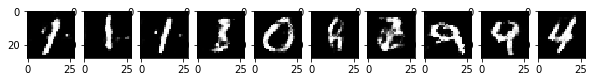

Epochs 2/5: Generator Loss: 9.438. Discriminator Loss: 0.05
Epochs 2/5: Generator Loss: 10.072. Discriminator Loss: 0.098
Epochs 2/5: Generator Loss: 9.96. Discriminator Loss: 0.033
Epochs 2/5: Generator Loss: 8.496. Discriminator Loss: 0.046
Epochs 2/5: Generator Loss: 8.917. Discriminator Loss: 0.051
Epochs 2/5: Generator Loss: 8.184. Discriminator Loss: 0.06
Epochs 2/5: Generator Loss: 8.794. Discriminator Loss: 0.045
Epochs 2/5: Generator Loss: 8.353. Discriminator Loss: 0.043
Epochs 2/5: Generator Loss: 8.856. Discriminator Loss: 0.038
Epochs 2/5: Generator Loss: 7.984. Discriminator Loss: 0.056


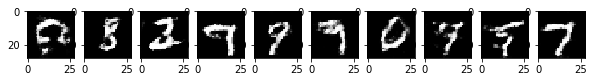

Epochs 2/5: Generator Loss: 8.199. Discriminator Loss: 0.067
Epochs 2/5: Generator Loss: 7.75. Discriminator Loss: 0.07
Epochs 2/5: Generator Loss: 8.287. Discriminator Loss: 0.052
Epochs 2/5: Generator Loss: 9.037. Discriminator Loss: 0.045
Epochs 2/5: Generator Loss: 8.96. Discriminator Loss: 0.08
Epochs 2/5: Generator Loss: 9.931. Discriminator Loss: 0.042
Epochs 2/5: Generator Loss: 9.205. Discriminator Loss: 0.074
Epochs 2/5: Generator Loss: 9.371. Discriminator Loss: 0.037
Epochs 2/5: Generator Loss: 9.144. Discriminator Loss: 0.093
Epochs 2/5: Generator Loss: 9.846. Discriminator Loss: 0.05


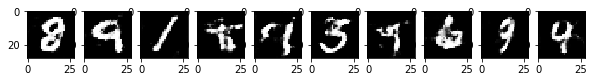

Epochs 2/5: Generator Loss: 9.417. Discriminator Loss: 0.075
Epochs 2/5: Generator Loss: 8.216. Discriminator Loss: 0.066
Epochs 3/5: Generator Loss: 9.186. Discriminator Loss: 0.046
Epochs 3/5: Generator Loss: 8.645. Discriminator Loss: 0.041
Epochs 3/5: Generator Loss: 8.604. Discriminator Loss: 0.056
Epochs 3/5: Generator Loss: 9.214. Discriminator Loss: 0.044
Epochs 3/5: Generator Loss: 9.297. Discriminator Loss: 0.073
Epochs 3/5: Generator Loss: 8.75. Discriminator Loss: 0.045
Epochs 3/5: Generator Loss: 8.334. Discriminator Loss: 0.049
Epochs 3/5: Generator Loss: 8.645. Discriminator Loss: 0.053


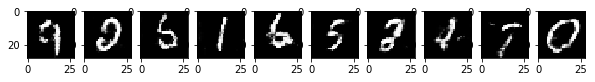

Epochs 3/5: Generator Loss: 7.95. Discriminator Loss: 0.063
Epochs 3/5: Generator Loss: 8.354. Discriminator Loss: 0.073
Epochs 3/5: Generator Loss: 9.416. Discriminator Loss: 0.042
Epochs 3/5: Generator Loss: 9.837. Discriminator Loss: 0.043
Epochs 3/5: Generator Loss: 8.701. Discriminator Loss: 0.06
Epochs 3/5: Generator Loss: 8.783. Discriminator Loss: 0.05
Epochs 3/5: Generator Loss: 9.374. Discriminator Loss: 0.044
Epochs 3/5: Generator Loss: 9.533. Discriminator Loss: 0.028
Epochs 3/5: Generator Loss: 8.924. Discriminator Loss: 0.042
Epochs 3/5: Generator Loss: 9.334. Discriminator Loss: 0.056


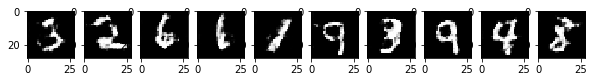

Epochs 3/5: Generator Loss: 9.925. Discriminator Loss: 0.031
Epochs 3/5: Generator Loss: 9.869. Discriminator Loss: 0.04
Epochs 3/5: Generator Loss: 9.461. Discriminator Loss: 0.04
Epochs 3/5: Generator Loss: 9.593. Discriminator Loss: 0.056
Epochs 3/5: Generator Loss: 9.599. Discriminator Loss: 0.057
Epochs 3/5: Generator Loss: 10.19. Discriminator Loss: 0.04
Epochs 3/5: Generator Loss: 9.764. Discriminator Loss: 0.039
Epochs 3/5: Generator Loss: 9.025. Discriminator Loss: 0.042
Epochs 3/5: Generator Loss: 9.818. Discriminator Loss: 0.027
Epochs 3/5: Generator Loss: 8.33. Discriminator Loss: 0.07


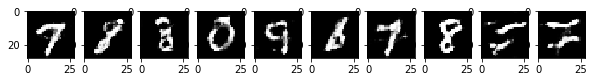

Epochs 3/5: Generator Loss: 9.165. Discriminator Loss: 0.043
Epochs 3/5: Generator Loss: 10.067. Discriminator Loss: 0.039
Epochs 3/5: Generator Loss: 9.405. Discriminator Loss: 0.057
Epochs 3/5: Generator Loss: 8.953. Discriminator Loss: 0.043
Epochs 3/5: Generator Loss: 9.328. Discriminator Loss: 0.033
Epochs 3/5: Generator Loss: 8.865. Discriminator Loss: 0.039
Epochs 3/5: Generator Loss: 9.261. Discriminator Loss: 0.033
Epochs 3/5: Generator Loss: 10.188. Discriminator Loss: 0.051
Epochs 3/5: Generator Loss: 9.138. Discriminator Loss: 0.052
Epochs 3/5: Generator Loss: 9.233. Discriminator Loss: 0.037


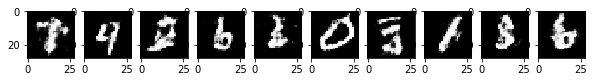

Epochs 3/5: Generator Loss: 9.237. Discriminator Loss: 0.042
Epochs 3/5: Generator Loss: 9.447. Discriminator Loss: 0.036
Epochs 3/5: Generator Loss: 8.933. Discriminator Loss: 0.051
Epochs 3/5: Generator Loss: 9.614. Discriminator Loss: 0.03
Epochs 3/5: Generator Loss: 9.115. Discriminator Loss: 0.049
Epochs 3/5: Generator Loss: 10.775. Discriminator Loss: 0.036
Epochs 3/5: Generator Loss: 11.326. Discriminator Loss: 0.029
Epochs 3/5: Generator Loss: 10.65. Discriminator Loss: 0.027
Epochs 3/5: Generator Loss: 9.448. Discriminator Loss: 0.033
Epochs 3/5: Generator Loss: 9.008. Discriminator Loss: 0.04


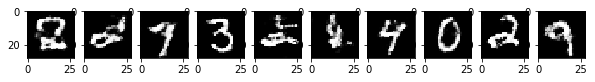

Epochs 3/5: Generator Loss: 9.82. Discriminator Loss: 0.035
Epochs 3/5: Generator Loss: 9.34. Discriminator Loss: 0.041
Epochs 3/5: Generator Loss: 9.913. Discriminator Loss: 0.049
Epochs 3/5: Generator Loss: 8.755. Discriminator Loss: 0.047
Epochs 3/5: Generator Loss: 9.094. Discriminator Loss: 0.034
Epochs 3/5: Generator Loss: 9.706. Discriminator Loss: 0.029
Epochs 3/5: Generator Loss: 9.158. Discriminator Loss: 0.087
Epochs 3/5: Generator Loss: 9.222. Discriminator Loss: 0.047
Epochs 3/5: Generator Loss: 8.916. Discriminator Loss: 0.056
Epochs 3/5: Generator Loss: 9.685. Discriminator Loss: 0.047


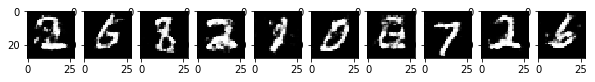

Epochs 3/5: Generator Loss: 10.054. Discriminator Loss: 0.047
Epochs 3/5: Generator Loss: 9.951. Discriminator Loss: 0.032
Epochs 3/5: Generator Loss: 10.004. Discriminator Loss: 0.035
Epochs 3/5: Generator Loss: 10.171. Discriminator Loss: 0.051
Epochs 3/5: Generator Loss: 10.504. Discriminator Loss: 0.024
Epochs 3/5: Generator Loss: 10.149. Discriminator Loss: 0.036
Epochs 3/5: Generator Loss: 10.402. Discriminator Loss: 0.027
Epochs 3/5: Generator Loss: 10.508. Discriminator Loss: 0.03
Epochs 3/5: Generator Loss: 9.275. Discriminator Loss: 0.033
Epochs 3/5: Generator Loss: 10.934. Discriminator Loss: 0.062


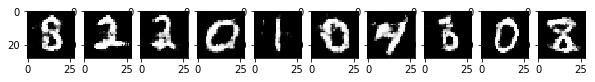

Epochs 3/5: Generator Loss: 10.348. Discriminator Loss: 0.038
Epochs 3/5: Generator Loss: 10.039. Discriminator Loss: 0.049
Epochs 3/5: Generator Loss: 9.88. Discriminator Loss: 0.029
Epochs 3/5: Generator Loss: 10.16. Discriminator Loss: 0.04
Epochs 3/5: Generator Loss: 10.571. Discriminator Loss: 0.035
Epochs 3/5: Generator Loss: 10.368. Discriminator Loss: 0.034
Epochs 3/5: Generator Loss: 9.816. Discriminator Loss: 0.026
Epochs 3/5: Generator Loss: 9.174. Discriminator Loss: 0.031
Epochs 3/5: Generator Loss: 9.796. Discriminator Loss: 0.03
Epochs 3/5: Generator Loss: 10.247. Discriminator Loss: 0.046


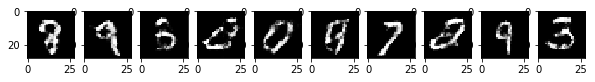

Epochs 3/5: Generator Loss: 10.671. Discriminator Loss: 0.043
Epochs 3/5: Generator Loss: 9.822. Discriminator Loss: 0.089
Epochs 3/5: Generator Loss: 9.879. Discriminator Loss: 0.036
Epochs 3/5: Generator Loss: 9.898. Discriminator Loss: 0.029
Epochs 3/5: Generator Loss: 9.229. Discriminator Loss: 0.031
Epochs 3/5: Generator Loss: 10.19. Discriminator Loss: 0.028
Epochs 3/5: Generator Loss: 9.298. Discriminator Loss: 0.034
Epochs 3/5: Generator Loss: 9.563. Discriminator Loss: 0.036
Epochs 3/5: Generator Loss: 9.802. Discriminator Loss: 0.026
Epochs 3/5: Generator Loss: 9.383. Discriminator Loss: 0.032


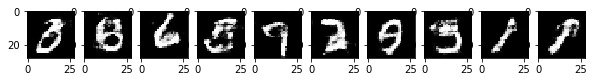

Epochs 3/5: Generator Loss: 9.538. Discriminator Loss: 0.033
Epochs 3/5: Generator Loss: 9.712. Discriminator Loss: 0.036
Epochs 3/5: Generator Loss: 9.685. Discriminator Loss: 0.05
Epochs 3/5: Generator Loss: 10.046. Discriminator Loss: 0.036
Epochs 3/5: Generator Loss: 11.27. Discriminator Loss: 0.031
Epochs 3/5: Generator Loss: 10.244. Discriminator Loss: 0.031
Epochs 3/5: Generator Loss: 10.588. Discriminator Loss: 0.032
Epochs 3/5: Generator Loss: 10.145. Discriminator Loss: 0.07
Epochs 3/5: Generator Loss: 10.331. Discriminator Loss: 0.032
Epochs 3/5: Generator Loss: 9.902. Discriminator Loss: 0.026


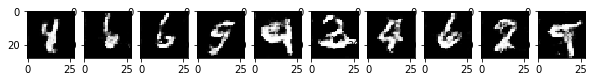

Epochs 3/5: Generator Loss: 9.447. Discriminator Loss: 0.053
Epochs 3/5: Generator Loss: 10.334. Discriminator Loss: 0.024
Epochs 3/5: Generator Loss: 10.108. Discriminator Loss: 0.025
Epochs 3/5: Generator Loss: 11.056. Discriminator Loss: 0.044
Epochs 3/5: Generator Loss: 10.769. Discriminator Loss: 0.024
Epochs 3/5: Generator Loss: 9.827. Discriminator Loss: 0.051
Epochs 3/5: Generator Loss: 10.718. Discriminator Loss: 0.025
Epochs 3/5: Generator Loss: 9.596. Discriminator Loss: 0.041
Epochs 3/5: Generator Loss: 10.504. Discriminator Loss: 0.028
Epochs 3/5: Generator Loss: 10.505. Discriminator Loss: 0.048


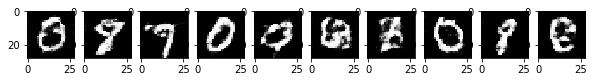

Epochs 3/5: Generator Loss: 10.736. Discriminator Loss: 0.032
Epochs 3/5: Generator Loss: 11.482. Discriminator Loss: 0.04
Epochs 3/5: Generator Loss: 11.022. Discriminator Loss: 0.027
Epochs 3/5: Generator Loss: 10.348. Discriminator Loss: 0.027
Epochs 3/5: Generator Loss: 9.526. Discriminator Loss: 0.035
Epochs 3/5: Generator Loss: 9.903. Discriminator Loss: 0.026
Epochs 3/5: Generator Loss: 9.563. Discriminator Loss: 0.03
Epochs 3/5: Generator Loss: 10.483. Discriminator Loss: 0.028
Epochs 3/5: Generator Loss: 10.496. Discriminator Loss: 0.023
Epochs 3/5: Generator Loss: 10.218. Discriminator Loss: 0.022


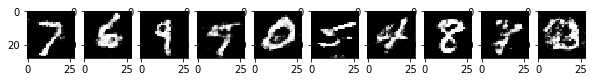

Epochs 3/5: Generator Loss: 10.506. Discriminator Loss: 0.023
Epochs 3/5: Generator Loss: 9.817. Discriminator Loss: 0.04
Epochs 3/5: Generator Loss: 10.557. Discriminator Loss: 0.058
Epochs 3/5: Generator Loss: 11.444. Discriminator Loss: 0.023
Epochs 3/5: Generator Loss: 10.996. Discriminator Loss: 0.033
Epochs 3/5: Generator Loss: 11.539. Discriminator Loss: 0.025
Epochs 3/5: Generator Loss: 11.214. Discriminator Loss: 0.036
Epochs 3/5: Generator Loss: 10.973. Discriminator Loss: 0.042
Epochs 3/5: Generator Loss: 10.714. Discriminator Loss: 0.033
Epochs 3/5: Generator Loss: 10.704. Discriminator Loss: 0.034


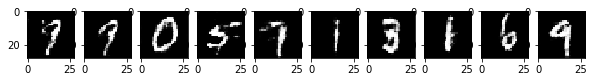

Epochs 3/5: Generator Loss: 10.277. Discriminator Loss: 0.039
Epochs 3/5: Generator Loss: 9.545. Discriminator Loss: 0.031
Epochs 3/5: Generator Loss: 10.511. Discriminator Loss: 0.04
Epochs 3/5: Generator Loss: 10.785. Discriminator Loss: 0.032
Epochs 3/5: Generator Loss: 10.851. Discriminator Loss: 0.029
Epochs 3/5: Generator Loss: 10.474. Discriminator Loss: 0.032
Epochs 3/5: Generator Loss: 10.412. Discriminator Loss: 0.025
Epochs 3/5: Generator Loss: 9.561. Discriminator Loss: 0.089
Epochs 3/5: Generator Loss: 10.564. Discriminator Loss: 0.032
Epochs 3/5: Generator Loss: 10.588. Discriminator Loss: 0.025


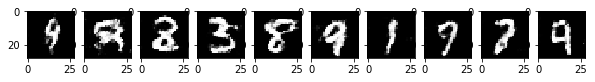

Epochs 3/5: Generator Loss: 10.538. Discriminator Loss: 0.03
Epochs 3/5: Generator Loss: 10.814. Discriminator Loss: 0.046
Epochs 3/5: Generator Loss: 10.761. Discriminator Loss: 0.031
Epochs 3/5: Generator Loss: 10.663. Discriminator Loss: 0.031
Epochs 3/5: Generator Loss: 10.989. Discriminator Loss: 0.05
Epochs 3/5: Generator Loss: 11.029. Discriminator Loss: 0.039
Epochs 3/5: Generator Loss: 11.407. Discriminator Loss: 0.018
Epochs 3/5: Generator Loss: 10.252. Discriminator Loss: 0.027
Epochs 3/5: Generator Loss: 10.006. Discriminator Loss: 0.036
Epochs 3/5: Generator Loss: 10.3. Discriminator Loss: 0.026


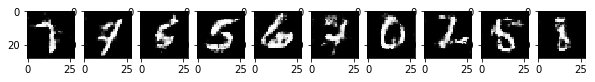

Epochs 3/5: Generator Loss: 9.773. Discriminator Loss: 0.04
Epochs 3/5: Generator Loss: 10.498. Discriminator Loss: 0.029
Epochs 3/5: Generator Loss: 10.396. Discriminator Loss: 0.021
Epochs 3/5: Generator Loss: 10.08. Discriminator Loss: 0.033
Epochs 3/5: Generator Loss: 10.434. Discriminator Loss: 0.029
Epochs 3/5: Generator Loss: 10.869. Discriminator Loss: 0.02
Epochs 3/5: Generator Loss: 11.057. Discriminator Loss: 0.029
Epochs 3/5: Generator Loss: 10.594. Discriminator Loss: 0.03
Epochs 3/5: Generator Loss: 10.654. Discriminator Loss: 0.026
Epochs 3/5: Generator Loss: 11.081. Discriminator Loss: 0.027


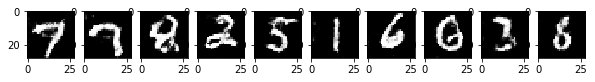

Epochs 3/5: Generator Loss: 11.155. Discriminator Loss: 0.03
Epochs 3/5: Generator Loss: 10.878. Discriminator Loss: 0.023
Epochs 3/5: Generator Loss: 10.856. Discriminator Loss: 0.021
Epochs 3/5: Generator Loss: 11.105. Discriminator Loss: 0.045
Epochs 3/5: Generator Loss: 11.471. Discriminator Loss: 0.043
Epochs 3/5: Generator Loss: 11.35. Discriminator Loss: 0.03
Epochs 3/5: Generator Loss: 11.987. Discriminator Loss: 0.034
Epochs 3/5: Generator Loss: 11.537. Discriminator Loss: 0.025
Epochs 3/5: Generator Loss: 11.35. Discriminator Loss: 0.031
Epochs 3/5: Generator Loss: 11.238. Discriminator Loss: 0.024


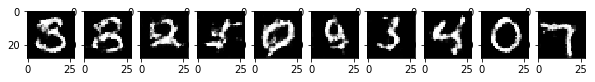

Epochs 3/5: Generator Loss: 11.512. Discriminator Loss: 0.029
Epochs 3/5: Generator Loss: 10.962. Discriminator Loss: 0.041
Epochs 3/5: Generator Loss: 10.474. Discriminator Loss: 0.036
Epochs 3/5: Generator Loss: 11.668. Discriminator Loss: 0.03
Epochs 3/5: Generator Loss: 10.778. Discriminator Loss: 0.022
Epochs 3/5: Generator Loss: 9.5. Discriminator Loss: 0.037
Epochs 3/5: Generator Loss: 10.356. Discriminator Loss: 0.031
Epochs 3/5: Generator Loss: 10.335. Discriminator Loss: 0.026
Epochs 3/5: Generator Loss: 10.249. Discriminator Loss: 0.026
Epochs 3/5: Generator Loss: 10.239. Discriminator Loss: 0.04


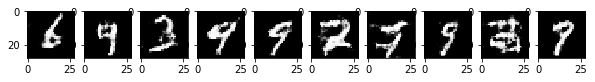

Epochs 3/5: Generator Loss: 11.228. Discriminator Loss: 0.019
Epochs 3/5: Generator Loss: 10.959. Discriminator Loss: 0.031
Epochs 3/5: Generator Loss: 11.094. Discriminator Loss: 0.04
Epochs 3/5: Generator Loss: 11.183. Discriminator Loss: 0.02
Epochs 3/5: Generator Loss: 11.594. Discriminator Loss: 0.024
Epochs 3/5: Generator Loss: 10.58. Discriminator Loss: 0.022
Epochs 3/5: Generator Loss: 10.546. Discriminator Loss: 0.027
Epochs 3/5: Generator Loss: 11.385. Discriminator Loss: 0.03
Epochs 3/5: Generator Loss: 10.592. Discriminator Loss: 0.03
Epochs 4/5: Generator Loss: 8.065. Discriminator Loss: 0.183


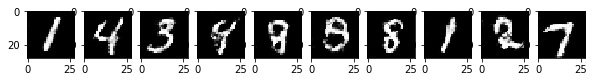

Epochs 4/5: Generator Loss: 13.137. Discriminator Loss: 0.011
Epochs 4/5: Generator Loss: 11.38. Discriminator Loss: 0.017
Epochs 4/5: Generator Loss: 10.164. Discriminator Loss: 0.028
Epochs 4/5: Generator Loss: 10.174. Discriminator Loss: 0.034
Epochs 4/5: Generator Loss: 11.125. Discriminator Loss: 0.021
Epochs 4/5: Generator Loss: 10.082. Discriminator Loss: 0.026
Epochs 4/5: Generator Loss: 10.215. Discriminator Loss: 0.026
Epochs 4/5: Generator Loss: 9.268. Discriminator Loss: 0.036
Epochs 4/5: Generator Loss: 10.125. Discriminator Loss: 0.022
Epochs 4/5: Generator Loss: 9.41. Discriminator Loss: 0.033


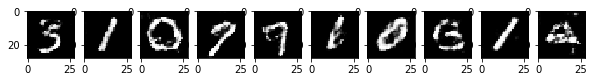

Epochs 4/5: Generator Loss: 10.798. Discriminator Loss: 0.044
Epochs 4/5: Generator Loss: 12.646. Discriminator Loss: 0.014
Epochs 4/5: Generator Loss: 10.096. Discriminator Loss: 0.032
Epochs 4/5: Generator Loss: 10.755. Discriminator Loss: 0.052
Epochs 4/5: Generator Loss: 11.736. Discriminator Loss: 0.027
Epochs 4/5: Generator Loss: 11.911. Discriminator Loss: 0.017
Epochs 4/5: Generator Loss: 11.409. Discriminator Loss: 0.023
Epochs 4/5: Generator Loss: 12.161. Discriminator Loss: 0.016
Epochs 4/5: Generator Loss: 12.834. Discriminator Loss: 0.019
Epochs 4/5: Generator Loss: 11.845. Discriminator Loss: 0.02


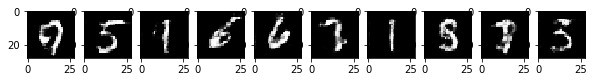

Epochs 4/5: Generator Loss: 11.247. Discriminator Loss: 0.022
Epochs 4/5: Generator Loss: 11.114. Discriminator Loss: 0.019
Epochs 4/5: Generator Loss: 10.765. Discriminator Loss: 0.026
Epochs 4/5: Generator Loss: 11.045. Discriminator Loss: 0.023
Epochs 4/5: Generator Loss: 11.558. Discriminator Loss: 0.044
Epochs 4/5: Generator Loss: 12.094. Discriminator Loss: 0.027
Epochs 4/5: Generator Loss: 11.62. Discriminator Loss: 0.029
Epochs 4/5: Generator Loss: 12.092. Discriminator Loss: 0.014
Epochs 4/5: Generator Loss: 11.152. Discriminator Loss: 0.021
Epochs 4/5: Generator Loss: 11.503. Discriminator Loss: 0.014


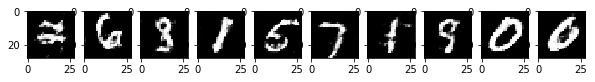

Epochs 4/5: Generator Loss: 9.779. Discriminator Loss: 0.025
Epochs 4/5: Generator Loss: 10.107. Discriminator Loss: 0.027
Epochs 4/5: Generator Loss: 9.842. Discriminator Loss: 0.023
Epochs 4/5: Generator Loss: 9.613. Discriminator Loss: 0.025
Epochs 4/5: Generator Loss: 9.686. Discriminator Loss: 0.021
Epochs 4/5: Generator Loss: 9.857. Discriminator Loss: 0.023
Epochs 4/5: Generator Loss: 10.007. Discriminator Loss: 0.024
Epochs 4/5: Generator Loss: 10.376. Discriminator Loss: 0.02
Epochs 4/5: Generator Loss: 9.66. Discriminator Loss: 0.029
Epochs 4/5: Generator Loss: 10.522. Discriminator Loss: 0.024


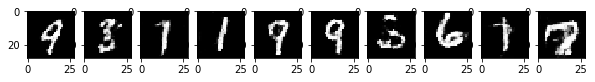

Epochs 4/5: Generator Loss: 11.064. Discriminator Loss: 0.021
Epochs 4/5: Generator Loss: 11.007. Discriminator Loss: 0.018
Epochs 4/5: Generator Loss: 10.873. Discriminator Loss: 0.024
Epochs 4/5: Generator Loss: 11.594. Discriminator Loss: 0.018
Epochs 4/5: Generator Loss: 11.423. Discriminator Loss: 0.074
Epochs 4/5: Generator Loss: 12.339. Discriminator Loss: 0.014
Epochs 4/5: Generator Loss: 10.858. Discriminator Loss: 0.024
Epochs 4/5: Generator Loss: 11.091. Discriminator Loss: 0.022
Epochs 4/5: Generator Loss: 11.884. Discriminator Loss: 0.191
Epochs 4/5: Generator Loss: 11.349. Discriminator Loss: 0.017


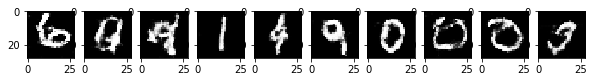

Epochs 4/5: Generator Loss: 10.419. Discriminator Loss: 0.021
Epochs 4/5: Generator Loss: 10.164. Discriminator Loss: 0.024
Epochs 4/5: Generator Loss: 10.428. Discriminator Loss: 0.026
Epochs 4/5: Generator Loss: 10.504. Discriminator Loss: 0.019
Epochs 4/5: Generator Loss: 11.129. Discriminator Loss: 0.015
Epochs 4/5: Generator Loss: 10.806. Discriminator Loss: 0.014
Epochs 4/5: Generator Loss: 10.459. Discriminator Loss: 0.02
Epochs 4/5: Generator Loss: 10.225. Discriminator Loss: 0.022
Epochs 4/5: Generator Loss: 10.767. Discriminator Loss: 0.024
Epochs 4/5: Generator Loss: 10.903. Discriminator Loss: 0.018


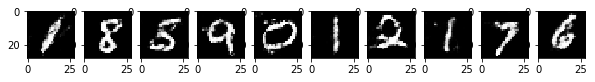

Epochs 4/5: Generator Loss: 10.046. Discriminator Loss: 0.023
Epochs 4/5: Generator Loss: 10.484. Discriminator Loss: 0.065
Epochs 4/5: Generator Loss: 10.985. Discriminator Loss: 0.02
Epochs 4/5: Generator Loss: 11.289. Discriminator Loss: 0.017
Epochs 4/5: Generator Loss: 11.676. Discriminator Loss: 0.019
Epochs 4/5: Generator Loss: 11.099. Discriminator Loss: 0.018
Epochs 4/5: Generator Loss: 11.992. Discriminator Loss: 0.032
Epochs 4/5: Generator Loss: 12.763. Discriminator Loss: 0.014
Epochs 4/5: Generator Loss: 10.916. Discriminator Loss: 0.065
Epochs 4/5: Generator Loss: 12.431. Discriminator Loss: 0.016


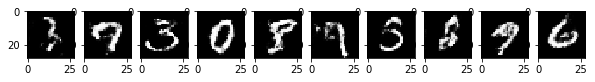

Epochs 4/5: Generator Loss: 11.479. Discriminator Loss: 0.015
Epochs 4/5: Generator Loss: 12.042. Discriminator Loss: 0.021
Epochs 4/5: Generator Loss: 12.953. Discriminator Loss: 0.023
Epochs 4/5: Generator Loss: 12.305. Discriminator Loss: 0.033
Epochs 4/5: Generator Loss: 12.355. Discriminator Loss: 0.016
Epochs 4/5: Generator Loss: 12.103. Discriminator Loss: 0.013
Epochs 4/5: Generator Loss: 11.519. Discriminator Loss: 0.014
Epochs 4/5: Generator Loss: 11.515. Discriminator Loss: 0.016
Epochs 4/5: Generator Loss: 11.522. Discriminator Loss: 0.015
Epochs 4/5: Generator Loss: 10.601. Discriminator Loss: 0.02


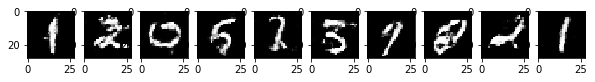

Epochs 4/5: Generator Loss: 10.617. Discriminator Loss: 0.014
Epochs 4/5: Generator Loss: 11.015. Discriminator Loss: 0.02
Epochs 4/5: Generator Loss: 10.828. Discriminator Loss: 0.014
Epochs 4/5: Generator Loss: 10.795. Discriminator Loss: 0.015
Epochs 4/5: Generator Loss: 10.293. Discriminator Loss: 0.022
Epochs 4/5: Generator Loss: 10.537. Discriminator Loss: 0.019
Epochs 4/5: Generator Loss: 11.963. Discriminator Loss: 0.027
Epochs 4/5: Generator Loss: 11.139. Discriminator Loss: 0.016
Epochs 4/5: Generator Loss: 10.878. Discriminator Loss: 0.017
Epochs 4/5: Generator Loss: 14.007. Discriminator Loss: 0.026


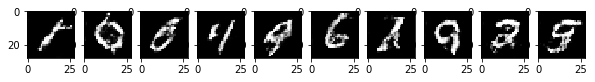

Epochs 4/5: Generator Loss: 14.286. Discriminator Loss: 0.022
Epochs 4/5: Generator Loss: 13.521. Discriminator Loss: 0.01
Epochs 4/5: Generator Loss: 13.095. Discriminator Loss: 0.02
Epochs 4/5: Generator Loss: 12.454. Discriminator Loss: 0.021
Epochs 4/5: Generator Loss: 11.54. Discriminator Loss: 0.032
Epochs 4/5: Generator Loss: 11.059. Discriminator Loss: 0.019
Epochs 4/5: Generator Loss: 11.451. Discriminator Loss: 0.015
Epochs 4/5: Generator Loss: 11.013. Discriminator Loss: 0.017
Epochs 4/5: Generator Loss: 12.316. Discriminator Loss: 0.024
Epochs 4/5: Generator Loss: 12.588. Discriminator Loss: 0.018


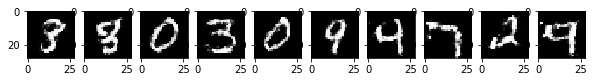

Epochs 4/5: Generator Loss: 10.782. Discriminator Loss: 0.019
Epochs 4/5: Generator Loss: 11.491. Discriminator Loss: 0.014
Epochs 4/5: Generator Loss: 11.548. Discriminator Loss: 0.015
Epochs 4/5: Generator Loss: 12.028. Discriminator Loss: 0.028
Epochs 4/5: Generator Loss: 13.332. Discriminator Loss: 0.037
Epochs 4/5: Generator Loss: 12.329. Discriminator Loss: 0.019
Epochs 4/5: Generator Loss: 11.079. Discriminator Loss: 0.016
Epochs 4/5: Generator Loss: 11.541. Discriminator Loss: 0.016
Epochs 4/5: Generator Loss: 10.944. Discriminator Loss: 0.015
Epochs 4/5: Generator Loss: 11.34. Discriminator Loss: 0.016


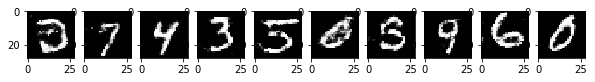

Epochs 4/5: Generator Loss: 10.294. Discriminator Loss: 0.018
Epochs 4/5: Generator Loss: 10.977. Discriminator Loss: 0.022
Epochs 4/5: Generator Loss: 11.21. Discriminator Loss: 0.013
Epochs 4/5: Generator Loss: 12.06. Discriminator Loss: 0.012
Epochs 4/5: Generator Loss: 11.012. Discriminator Loss: 0.02
Epochs 4/5: Generator Loss: 11.012. Discriminator Loss: 0.016
Epochs 4/5: Generator Loss: 11.113. Discriminator Loss: 0.023
Epochs 4/5: Generator Loss: 12.437. Discriminator Loss: 0.021
Epochs 4/5: Generator Loss: 11.67. Discriminator Loss: 0.014
Epochs 4/5: Generator Loss: 11.776. Discriminator Loss: 0.014


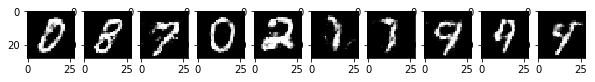

Epochs 4/5: Generator Loss: 11.105. Discriminator Loss: 0.015
Epochs 4/5: Generator Loss: 11.13. Discriminator Loss: 0.014
Epochs 4/5: Generator Loss: 10.683. Discriminator Loss: 0.015
Epochs 4/5: Generator Loss: 10.709. Discriminator Loss: 0.021
Epochs 4/5: Generator Loss: 10.763. Discriminator Loss: 0.016
Epochs 4/5: Generator Loss: 10.962. Discriminator Loss: 0.014
Epochs 4/5: Generator Loss: 10.34. Discriminator Loss: 0.02
Epochs 4/5: Generator Loss: 10.685. Discriminator Loss: 0.018
Epochs 4/5: Generator Loss: 10.459. Discriminator Loss: 0.031
Epochs 4/5: Generator Loss: 11.327. Discriminator Loss: 0.014


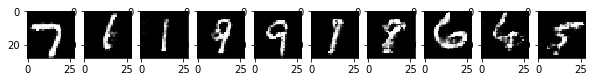

Epochs 4/5: Generator Loss: 11.472. Discriminator Loss: 0.022
Epochs 4/5: Generator Loss: 10.861. Discriminator Loss: 0.03
Epochs 4/5: Generator Loss: 11.833. Discriminator Loss: 0.02
Epochs 4/5: Generator Loss: 11.546. Discriminator Loss: 0.013
Epochs 4/5: Generator Loss: 10.961. Discriminator Loss: 0.017
Epochs 4/5: Generator Loss: 11.702. Discriminator Loss: 0.02
Epochs 4/5: Generator Loss: 12.682. Discriminator Loss: 0.02
Epochs 4/5: Generator Loss: 13.385. Discriminator Loss: 0.032
Epochs 4/5: Generator Loss: 13.036. Discriminator Loss: 0.028
Epochs 4/5: Generator Loss: 12.526. Discriminator Loss: 0.01


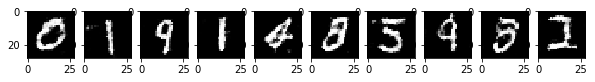

Epochs 4/5: Generator Loss: 12.768. Discriminator Loss: 0.013
Epochs 4/5: Generator Loss: 11.863. Discriminator Loss: 0.012
Epochs 4/5: Generator Loss: 11.974. Discriminator Loss: 0.014
Epochs 4/5: Generator Loss: 11.384. Discriminator Loss: 0.015
Epochs 4/5: Generator Loss: 11.51. Discriminator Loss: 0.011
Epochs 4/5: Generator Loss: 12.237. Discriminator Loss: 0.015
Epochs 4/5: Generator Loss: 13.462. Discriminator Loss: 0.012
Epochs 4/5: Generator Loss: 12.305. Discriminator Loss: 0.019
Epochs 4/5: Generator Loss: 12.078. Discriminator Loss: 0.022
Epochs 4/5: Generator Loss: 12.873. Discriminator Loss: 0.016


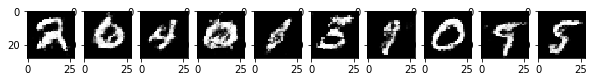

Epochs 4/5: Generator Loss: 11.974. Discriminator Loss: 0.048
Epochs 4/5: Generator Loss: 13.79. Discriminator Loss: 0.012
Epochs 4/5: Generator Loss: 13.759. Discriminator Loss: 0.063
Epochs 4/5: Generator Loss: 15.109. Discriminator Loss: 0.114
Epochs 4/5: Generator Loss: 15.303. Discriminator Loss: 0.04
Epochs 4/5: Generator Loss: 13.844. Discriminator Loss: 0.024
Epochs 4/5: Generator Loss: 13.994. Discriminator Loss: 0.021
Epochs 4/5: Generator Loss: 13.171. Discriminator Loss: 0.027
Epochs 4/5: Generator Loss: 14.713. Discriminator Loss: 0.106
Epochs 4/5: Generator Loss: 14.882. Discriminator Loss: 0.065


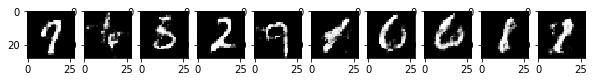

Epochs 4/5: Generator Loss: 13.657. Discriminator Loss: 0.02
Epochs 4/5: Generator Loss: 13.278. Discriminator Loss: 0.012
Epochs 4/5: Generator Loss: 13.628. Discriminator Loss: 0.02
Epochs 4/5: Generator Loss: 14.129. Discriminator Loss: 0.017
Epochs 4/5: Generator Loss: 13.934. Discriminator Loss: 0.02
Epochs 4/5: Generator Loss: 12.798. Discriminator Loss: 0.067
Epochs 4/5: Generator Loss: 13.745. Discriminator Loss: 0.021
Epochs 4/5: Generator Loss: 13.353. Discriminator Loss: 0.014
Epochs 4/5: Generator Loss: 13.982. Discriminator Loss: 0.019
Epochs 4/5: Generator Loss: 12.554. Discriminator Loss: 0.015


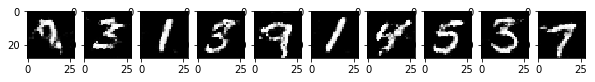

Epochs 4/5: Generator Loss: 11.73. Discriminator Loss: 0.018
Epochs 4/5: Generator Loss: 11.984. Discriminator Loss: 0.032
Epochs 4/5: Generator Loss: 11.366. Discriminator Loss: 0.026
Epochs 4/5: Generator Loss: 12.875. Discriminator Loss: 0.015
Epochs 4/5: Generator Loss: 12.985. Discriminator Loss: 0.032
Epochs 4/5: Generator Loss: 12.676. Discriminator Loss: 0.025
Epochs 4/5: Generator Loss: 11.165. Discriminator Loss: 0.032
Epochs 4/5: Generator Loss: 12.249. Discriminator Loss: 0.029
Epochs 4/5: Generator Loss: 11.447. Discriminator Loss: 0.02
Epochs 4/5: Generator Loss: 12.168. Discriminator Loss: 0.019


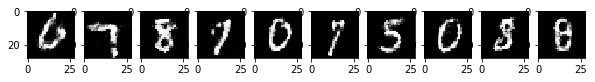

Epochs 4/5: Generator Loss: 12.63. Discriminator Loss: 0.018
Epochs 4/5: Generator Loss: 12.598. Discriminator Loss: 0.03
Epochs 4/5: Generator Loss: 12.584. Discriminator Loss: 0.025
Epochs 4/5: Generator Loss: 11.072. Discriminator Loss: 0.031
Epochs 4/5: Generator Loss: 12.609. Discriminator Loss: 0.015
Epochs 4/5: Generator Loss: 11.275. Discriminator Loss: 0.018
Epochs 4/5: Generator Loss: 10.807. Discriminator Loss: 0.087
Epochs 5/5: Generator Loss: 11.463. Discriminator Loss: 0.025
Epochs 5/5: Generator Loss: 11.646. Discriminator Loss: 0.015
Epochs 5/5: Generator Loss: 10.801. Discriminator Loss: 0.018


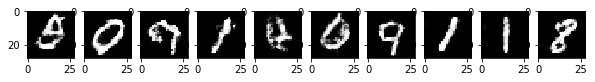

Epochs 5/5: Generator Loss: 10.437. Discriminator Loss: 0.02
Epochs 5/5: Generator Loss: 10.155. Discriminator Loss: 0.017
Epochs 5/5: Generator Loss: 11.152. Discriminator Loss: 0.016
Epochs 5/5: Generator Loss: 10.953. Discriminator Loss: 0.017
Epochs 5/5: Generator Loss: 10.906. Discriminator Loss: 0.017
Epochs 5/5: Generator Loss: 10.257. Discriminator Loss: 0.02
Epochs 5/5: Generator Loss: 10.337. Discriminator Loss: 0.024
Epochs 5/5: Generator Loss: 12.436. Discriminator Loss: 0.022
Epochs 5/5: Generator Loss: 12.727. Discriminator Loss: 0.014
Epochs 5/5: Generator Loss: 10.997. Discriminator Loss: 0.024


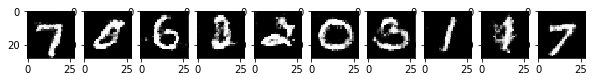

Epochs 5/5: Generator Loss: 10.451. Discriminator Loss: 0.024
Epochs 5/5: Generator Loss: 11.074. Discriminator Loss: 0.017
Epochs 5/5: Generator Loss: 10.762. Discriminator Loss: 0.017
Epochs 5/5: Generator Loss: 11.132. Discriminator Loss: 0.013
Epochs 5/5: Generator Loss: 11.163. Discriminator Loss: 0.022
Epochs 5/5: Generator Loss: 11.258. Discriminator Loss: 0.015
Epochs 5/5: Generator Loss: 11.081. Discriminator Loss: 0.015
Epochs 5/5: Generator Loss: 10.07. Discriminator Loss: 0.018
Epochs 5/5: Generator Loss: 11.341. Discriminator Loss: 0.016
Epochs 5/5: Generator Loss: 10.64. Discriminator Loss: 0.023


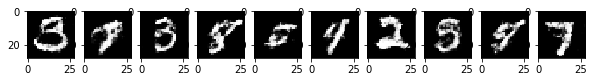

Epochs 5/5: Generator Loss: 11.298. Discriminator Loss: 0.014
Epochs 5/5: Generator Loss: 10.479. Discriminator Loss: 0.016
Epochs 5/5: Generator Loss: 11.133. Discriminator Loss: 0.013
Epochs 5/5: Generator Loss: 11.03. Discriminator Loss: 0.018
Epochs 5/5: Generator Loss: 10.352. Discriminator Loss: 0.021
Epochs 5/5: Generator Loss: 10.602. Discriminator Loss: 0.018
Epochs 5/5: Generator Loss: 10.616. Discriminator Loss: 0.016
Epochs 5/5: Generator Loss: 10.619. Discriminator Loss: 0.016
Epochs 5/5: Generator Loss: 10.607. Discriminator Loss: 0.017
Epochs 5/5: Generator Loss: 10.38. Discriminator Loss: 0.017


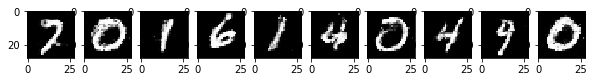

Epochs 5/5: Generator Loss: 10.006. Discriminator Loss: 0.019
Epochs 5/5: Generator Loss: 9.898. Discriminator Loss: 0.021
Epochs 5/5: Generator Loss: 11.531. Discriminator Loss: 0.013
Epochs 5/5: Generator Loss: 10.628. Discriminator Loss: 0.015
Epochs 5/5: Generator Loss: 10.351. Discriminator Loss: 0.016
Epochs 5/5: Generator Loss: 11.126. Discriminator Loss: 0.015
Epochs 5/5: Generator Loss: 10.718. Discriminator Loss: 0.014
Epochs 5/5: Generator Loss: 10.582. Discriminator Loss: 0.014
Epochs 5/5: Generator Loss: 10.737. Discriminator Loss: 0.014
Epochs 5/5: Generator Loss: 11.325. Discriminator Loss: 0.014


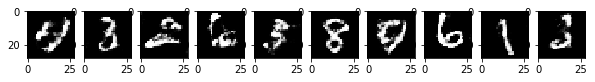

Epochs 5/5: Generator Loss: 12.091. Discriminator Loss: 0.009
Epochs 5/5: Generator Loss: 11.503. Discriminator Loss: 0.011
Epochs 5/5: Generator Loss: 11.477. Discriminator Loss: 0.011
Epochs 5/5: Generator Loss: 10.298. Discriminator Loss: 0.017
Epochs 5/5: Generator Loss: 11.167. Discriminator Loss: 0.013
Epochs 5/5: Generator Loss: 10.502. Discriminator Loss: 0.02
Epochs 5/5: Generator Loss: 10.931. Discriminator Loss: 0.014
Epochs 5/5: Generator Loss: 11.151. Discriminator Loss: 0.013
Epochs 5/5: Generator Loss: 9.683. Discriminator Loss: 0.021
Epochs 5/5: Generator Loss: 10.287. Discriminator Loss: 0.015


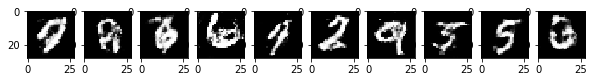

Epochs 5/5: Generator Loss: 10.558. Discriminator Loss: 0.013
Epochs 5/5: Generator Loss: 11.416. Discriminator Loss: 0.011
Epochs 5/5: Generator Loss: 10.397. Discriminator Loss: 0.016
Epochs 5/5: Generator Loss: 11.122. Discriminator Loss: 0.014
Epochs 5/5: Generator Loss: 10.952. Discriminator Loss: 0.014
Epochs 5/5: Generator Loss: 10.853. Discriminator Loss: 0.028
Epochs 5/5: Generator Loss: 11.515. Discriminator Loss: 0.017
Epochs 5/5: Generator Loss: 12.285. Discriminator Loss: 0.01
Epochs 5/5: Generator Loss: 11.994. Discriminator Loss: 0.01
Epochs 5/5: Generator Loss: 12.227. Discriminator Loss: 0.03


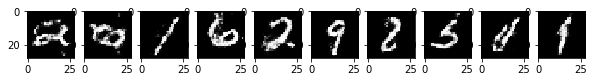

Epochs 5/5: Generator Loss: 12.333. Discriminator Loss: 0.013
Epochs 5/5: Generator Loss: 12.551. Discriminator Loss: 0.01
Epochs 5/5: Generator Loss: 12.03. Discriminator Loss: 0.01
Epochs 5/5: Generator Loss: 10.993. Discriminator Loss: 0.012
Epochs 5/5: Generator Loss: 11.852. Discriminator Loss: 0.01
Epochs 5/5: Generator Loss: 11.354. Discriminator Loss: 0.013
Epochs 5/5: Generator Loss: 11.76. Discriminator Loss: 0.009
Epochs 5/5: Generator Loss: 11.451. Discriminator Loss: 0.011
Epochs 5/5: Generator Loss: 11.662. Discriminator Loss: 0.01
Epochs 5/5: Generator Loss: 11.575. Discriminator Loss: 0.011


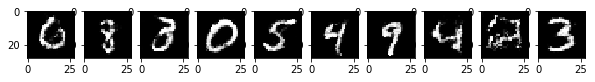

Epochs 5/5: Generator Loss: 11.603. Discriminator Loss: 0.01
Epochs 5/5: Generator Loss: 11.508. Discriminator Loss: 0.012
Epochs 5/5: Generator Loss: 11.285. Discriminator Loss: 0.013
Epochs 5/5: Generator Loss: 12.234. Discriminator Loss: 0.01
Epochs 5/5: Generator Loss: 11.848. Discriminator Loss: 0.015
Epochs 5/5: Generator Loss: 11.913. Discriminator Loss: 0.016
Epochs 5/5: Generator Loss: 12.112. Discriminator Loss: 0.013
Epochs 5/5: Generator Loss: 12.217. Discriminator Loss: 0.011
Epochs 5/5: Generator Loss: 12.889. Discriminator Loss: 0.009
Epochs 5/5: Generator Loss: 11.923. Discriminator Loss: 0.023


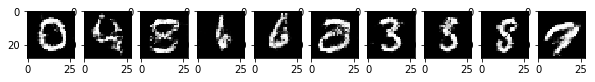

Epochs 5/5: Generator Loss: 12.871. Discriminator Loss: 0.01
Epochs 5/5: Generator Loss: 12.392. Discriminator Loss: 0.012
Epochs 5/5: Generator Loss: 12.016. Discriminator Loss: 0.014
Epochs 5/5: Generator Loss: 11.938. Discriminator Loss: 0.008
Epochs 5/5: Generator Loss: 11.253. Discriminator Loss: 0.012
Epochs 5/5: Generator Loss: 12.114. Discriminator Loss: 0.011
Epochs 5/5: Generator Loss: 12.688. Discriminator Loss: 0.006
Epochs 5/5: Generator Loss: 12.163. Discriminator Loss: 0.008
Epochs 5/5: Generator Loss: 11.224. Discriminator Loss: 0.012
Epochs 5/5: Generator Loss: 11.676. Discriminator Loss: 0.008


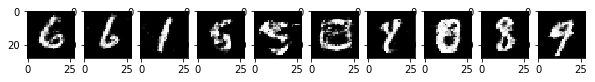

Epochs 5/5: Generator Loss: 11.326. Discriminator Loss: 0.01
Epochs 5/5: Generator Loss: 11.563. Discriminator Loss: 0.011
Epochs 5/5: Generator Loss: 11.182. Discriminator Loss: 0.012
Epochs 5/5: Generator Loss: 11.466. Discriminator Loss: 0.01
Epochs 5/5: Generator Loss: 11.111. Discriminator Loss: 0.012
Epochs 5/5: Generator Loss: 11.145. Discriminator Loss: 0.01
Epochs 5/5: Generator Loss: 11.48. Discriminator Loss: 0.009
Epochs 5/5: Generator Loss: 12.021. Discriminator Loss: 0.007
Epochs 5/5: Generator Loss: 11.802. Discriminator Loss: 0.01
Epochs 5/5: Generator Loss: 12.46. Discriminator Loss: 0.008


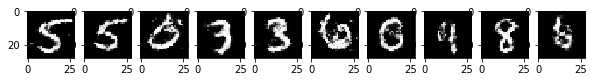

Epochs 5/5: Generator Loss: 11.642. Discriminator Loss: 0.009
Epochs 5/5: Generator Loss: 11.55. Discriminator Loss: 0.01
Epochs 5/5: Generator Loss: 11.677. Discriminator Loss: 0.023
Epochs 5/5: Generator Loss: 12.691. Discriminator Loss: 0.019
Epochs 5/5: Generator Loss: 14.333. Discriminator Loss: 0.006
Epochs 5/5: Generator Loss: 14.013. Discriminator Loss: 0.005
Epochs 5/5: Generator Loss: 12.288. Discriminator Loss: 0.009
Epochs 5/5: Generator Loss: 11.227. Discriminator Loss: 0.012
Epochs 5/5: Generator Loss: 11.398. Discriminator Loss: 0.012
Epochs 5/5: Generator Loss: 12.108. Discriminator Loss: 0.014


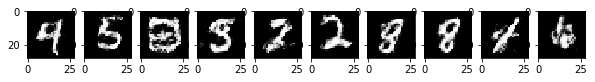

Epochs 5/5: Generator Loss: 12.062. Discriminator Loss: 0.013
Epochs 5/5: Generator Loss: 11.883. Discriminator Loss: 0.017
Epochs 5/5: Generator Loss: 13.684. Discriminator Loss: 0.011
Epochs 5/5: Generator Loss: 13.61. Discriminator Loss: 0.007
Epochs 5/5: Generator Loss: 12.509. Discriminator Loss: 0.009
Epochs 5/5: Generator Loss: 13.052. Discriminator Loss: 0.008
Epochs 5/5: Generator Loss: 12.579. Discriminator Loss: 0.007
Epochs 5/5: Generator Loss: 12.378. Discriminator Loss: 0.018
Epochs 5/5: Generator Loss: 14.701. Discriminator Loss: 0.009
Epochs 5/5: Generator Loss: 13.862. Discriminator Loss: 0.015


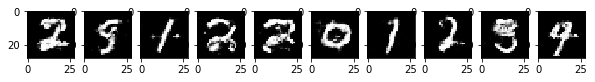

Epochs 5/5: Generator Loss: 20.424. Discriminator Loss: 1.053
Epochs 5/5: Generator Loss: 17.73. Discriminator Loss: 0.01
Epochs 5/5: Generator Loss: 15.299. Discriminator Loss: 0.01
Epochs 5/5: Generator Loss: 13.301. Discriminator Loss: 0.029
Epochs 5/5: Generator Loss: 15.668. Discriminator Loss: 0.051
Epochs 5/5: Generator Loss: 14.44. Discriminator Loss: 0.025
Epochs 5/5: Generator Loss: 14.344. Discriminator Loss: 0.017
Epochs 5/5: Generator Loss: 13.764. Discriminator Loss: 0.028
Epochs 5/5: Generator Loss: 14.024. Discriminator Loss: 0.019
Epochs 5/5: Generator Loss: 12.622. Discriminator Loss: 0.021


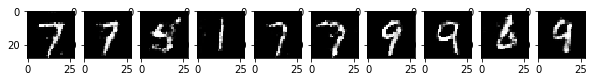

Epochs 5/5: Generator Loss: 12.229. Discriminator Loss: 0.064
Epochs 5/5: Generator Loss: 12.971. Discriminator Loss: 0.019
Epochs 5/5: Generator Loss: 12.041. Discriminator Loss: 0.034
Epochs 5/5: Generator Loss: 12.479. Discriminator Loss: 0.016
Epochs 5/5: Generator Loss: 11.191. Discriminator Loss: 0.024
Epochs 5/5: Generator Loss: 11.492. Discriminator Loss: 0.017
Epochs 5/5: Generator Loss: 11.445. Discriminator Loss: 0.021
Epochs 5/5: Generator Loss: 11.714. Discriminator Loss: 0.02
Epochs 5/5: Generator Loss: 11.818. Discriminator Loss: 0.013
Epochs 5/5: Generator Loss: 11.242. Discriminator Loss: 0.018


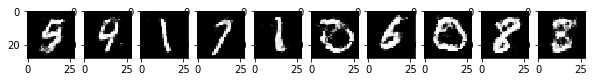

Epochs 5/5: Generator Loss: 11.671. Discriminator Loss: 0.021
Epochs 5/5: Generator Loss: 11.636. Discriminator Loss: 0.018
Epochs 5/5: Generator Loss: 12.854. Discriminator Loss: 0.026
Epochs 5/5: Generator Loss: 12.58. Discriminator Loss: 0.018
Epochs 5/5: Generator Loss: 11.99. Discriminator Loss: 0.02
Epochs 5/5: Generator Loss: 11.297. Discriminator Loss: 0.017
Epochs 5/5: Generator Loss: 12.397. Discriminator Loss: 0.023
Epochs 5/5: Generator Loss: 12.979. Discriminator Loss: 0.015
Epochs 5/5: Generator Loss: 12.491. Discriminator Loss: 0.011
Epochs 5/5: Generator Loss: 12.723. Discriminator Loss: 0.008


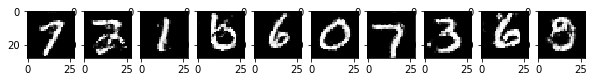

Epochs 5/5: Generator Loss: 12.356. Discriminator Loss: 0.011
Epochs 5/5: Generator Loss: 11.224. Discriminator Loss: 0.012
Epochs 5/5: Generator Loss: 10.563. Discriminator Loss: 0.019
Epochs 5/5: Generator Loss: 10.641. Discriminator Loss: 0.018
Epochs 5/5: Generator Loss: 10.919. Discriminator Loss: 0.013
Epochs 5/5: Generator Loss: 12.277. Discriminator Loss: 0.009
Epochs 5/5: Generator Loss: 11.448. Discriminator Loss: 0.012
Epochs 5/5: Generator Loss: 11.697. Discriminator Loss: 0.011
Epochs 5/5: Generator Loss: 11.079. Discriminator Loss: 0.013
Epochs 5/5: Generator Loss: 10.98. Discriminator Loss: 0.017


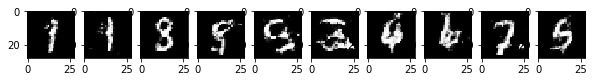

Epochs 5/5: Generator Loss: 11.623. Discriminator Loss: 0.011
Epochs 5/5: Generator Loss: 11.06. Discriminator Loss: 0.023
Epochs 5/5: Generator Loss: 11.381. Discriminator Loss: 0.014
Epochs 5/5: Generator Loss: 11.28. Discriminator Loss: 0.014
Epochs 5/5: Generator Loss: 11.784. Discriminator Loss: 0.012
Epochs 5/5: Generator Loss: 11.446. Discriminator Loss: 0.01
Epochs 5/5: Generator Loss: 10.845. Discriminator Loss: 0.012
Epochs 5/5: Generator Loss: 10.072. Discriminator Loss: 0.019
Epochs 5/5: Generator Loss: 11.402. Discriminator Loss: 0.01
Epochs 5/5: Generator Loss: 11.061. Discriminator Loss: 0.012


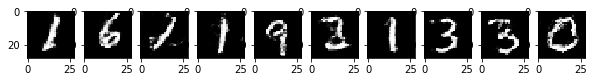

Epochs 5/5: Generator Loss: 10.191. Discriminator Loss: 0.018
Epochs 5/5: Generator Loss: 12.207. Discriminator Loss: 0.021
Epochs 5/5: Generator Loss: 12.783. Discriminator Loss: 0.012
Epochs 5/5: Generator Loss: 12.581. Discriminator Loss: 0.01
Epochs 5/5: Generator Loss: 12.455. Discriminator Loss: 0.022
Epochs 5/5: Generator Loss: 13.826. Discriminator Loss: 0.014
Epochs 5/5: Generator Loss: 14.01. Discriminator Loss: 0.01


In [ ]:
projection_data_path = '/Users/adalbertoclaudioquiros/Documents/Code/UofG/PhD/GANs'
dataset = Dataset(train_images, train_labels, test_images, test_labels, projection_data_path, validation=0.0, shuffle=True)

epochs = 5
batch_size = 32
z_dim = 100
learning_rate = 1e-4
beta1 = 0.5
image_type = 'gray'
alpha = 0.2
n_critic = 1

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, dataset, image_type, alpha, n_critic)